# <span style='font-family:"Times New Roman"'> <span styel=''>**COLORECTAL CANCER ANALYSIS**

*Emile Cohen*
    
*June 2020*

**Goal**: In this notebook, we want to understand what makes Colorectal Cancer a textbook case for the patterns we saw, and what are the major subcohorts that drive the signal.

---

In [19]:
%run -i '../../../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

## Interesting functions

In [3]:
from functools import reduce

def get_hotspots(df: pd.DataFrame, Sample_Type: str, group: list = None, group_type:str = None):
    data = df[df['Sample_Type'] == Sample_Type]
    
    if group and group_type:
        data = data[data[group_type].isin(group)]

    data_1 = get_groupby(data,'tp53_spot_1', 'count'); data_2 = get_groupby(data,'tp53_spot_2', 'count'); data_3 = get_groupby(data,'tp53_spot_3', 'count') ; data_4 = get_groupby(data,'tp53_spot_4', 'count') ; data_5 = get_groupby(data,'tp53_spot_5', 'count') 
    series_data = [data_1,data_2,data_3,data_4,data_5]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,
                                                how='outer'), series_data).fillna(0)

    df_merged.columns = ['count_1', 'count_2', 'count_3', 'count_4', 'count_5']
    df_merged['total'] = df_merged.sum(axis=1)
    df_merged = df_merged.sort_values(by='total', ascending=False)

    df_merged = df_merged.drop('nan')
    
    return df_merged

def get_hotspot_frac(df: pd.DataFrame, group_type:str = None, group: list = None, nb = 10):
    if group_type and group:
        df = df[df[group_type].isin(group)]
    result = [['spot', '#', 'frac']]
    for spot in get_groupby(df, 'tp53_spot_1', 'count').sort_values(by='count', ascending=False).head(nb).index.tolist():
        result.append([spot,df[df['tp53_spot_1'] == spot].frac_genome_altered.shape[0], df[df['tp53_spot_1'] == spot].frac_genome_altered.median()])

    return pd.DataFrame(result)


def boxplot_sampletype(df: pd.DataFrame, group:str, palette, order, metrics: str, figsize= (10,3), title: str = '', title_font: int=12, xlim=[0,1]):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)

    sns.boxplot(y=metrics, x=group,data=df,ax=ax, dodge=False,order=order, palette=palette).set_title(title, weight='bold', fontsize=title_font)
    
    groupby_ = get_groupby(df,group, 'count')
    
    labels = []
    for element in order:
        labels.append(element + '\n('+ str(groupby_.loc[element].values[0])+')')
    
    
    
    ax.set_xticklabels(labels)
    style(ax)
    ax.set_ylim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax


# Let's give a look at medians and statistics

def get_statistics(df: pd.DataFrame, group:str, metrics: str, group_list: list):
    group_1 = df[df[group] == group_list[0]][metrics]
    group_2 = df[df[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]


    return pd.DataFrame(results)

## Master Definition and Filtering

In [4]:
cancer = 'Colorectal Cancer'

In [5]:
master_no_wgd = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')

master_no_wgd_cancer = master_no_wgd[master_no_wgd['Cancer_Type'] == cancer]
master_wgd_cancer = master_wgd[master_wgd['Cancer_Type'] == cancer]

# What makes Colorectal Cancer a TextBook Case?

## WGD Proportion

Colorectal Cancer is the third bigger cancer in our cohort. Colorectal Cancer has an average proportion of WGD - around 38%
<img src="wgd_proportion.png" width=700 length=700>

## Cancer Panel

* Colorectal Cancer is one of the most represented cancer in MSK-Impact Cohort.
* Enriched for Primary Samples
* It is enriched for >=1_LOSS subgroup, and shows a depletion of 0_HETLOSS subgroup.
* This difference in subgroup proportion implies that COlorectal is enriched for tp53 bi-allelic state (darker green in the last plot) in both Primary and Metastatic cohorts.

<img src="colorectal_header.png" width=700 length=700>
<img src="colorectal_panel.png" width=1000 length=700>

## Genome Instability

Colorectal Cancer shows a significant difference in Genome Instability between TP53 Mono-Allelic and Bi-Allelic subgroups - and has a lot of samples in both groups.
<img src="pancancer_gi.png" width=1000 length=600>

In the TP53 subgroup Pan Cancer plot that follows, we can see 3 important signals:
* The GI difference between *0_HETLOSS* and *1_WILD_TYPE*, two likely mono-allelic subgroups
* *1_WILD_TYPE* GI is very low compared to other subgroups
* Bi Allelic Subgroups - *>=1_LOSS* and *>=1_cnLOH* - have higher GI  than other subgroups and the difference is significant




<img src="pancancer_gi_sub_b.png" width=1000 length=600>



## Co Drivers

Colorectal Cancer is one of the 2 cancers (Endometrial is the other) that shows a difference in # of co-drivers between *0_HETLOSS* and *1_WILD_TYPE*. This is consitent with the fact that *1_WILD_TYPE* is 'very' stable, thus it does need more co drivers than other subgroups.
<img src="driver_count.png" width=1000 length=600>|

# Cancer Investigation
In this section, our goal is to find subcohorts that lead the signals observed. Here are the different subcohort we will create:
* Hotspot Analysis: splitting on 273 / 248 / 175 / Missense / Truncated / In Frame
* CCF Analysis
* SNV/INDEL Analysis

## Hotspot Analysis
In this section, we cut our cohort to only keep samples with exactly one TP53 mutation, for simplicity.

In [33]:
master_hotspot = master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] == 1]

In [69]:
get_hotspot_frac(df=master_hotspot,
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,273,94,0.3135
2,175,71,0.35
3,248,62,0.306
4,282,48,0.32
5,nan,35,0.307
6,245,32,0.3265
7,213,23,0.304
8,196,21,0.315
9,342,16,0.265


### Entire Cohort

,count
tp53_vc_group_1,
truncated,251
missense,224
273,94
hotspot,94
175,71
248,62
in_frame,16


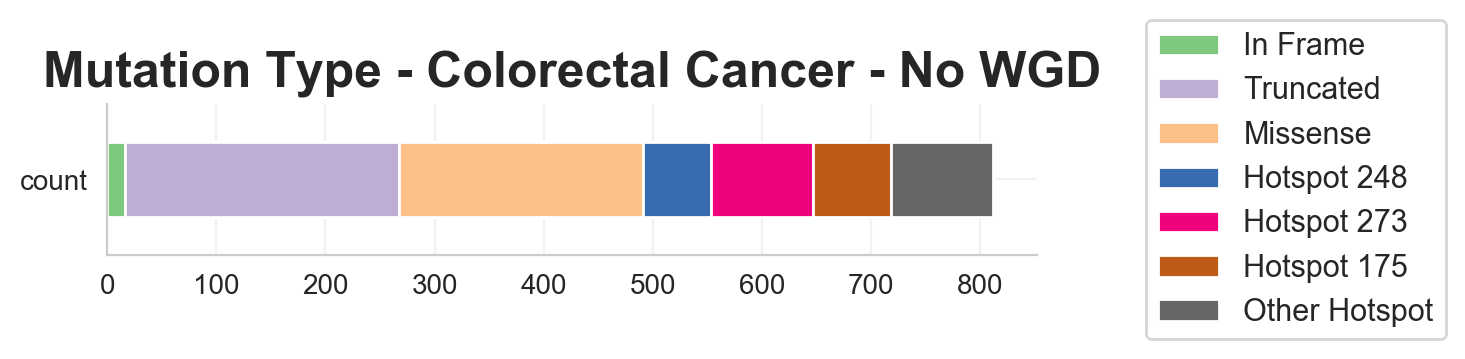

In [34]:
h = get_groupby(master_hotspot,'tp53_vc_group_1', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[mutation_list]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=11)
ax.set_title('Mutation Type - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

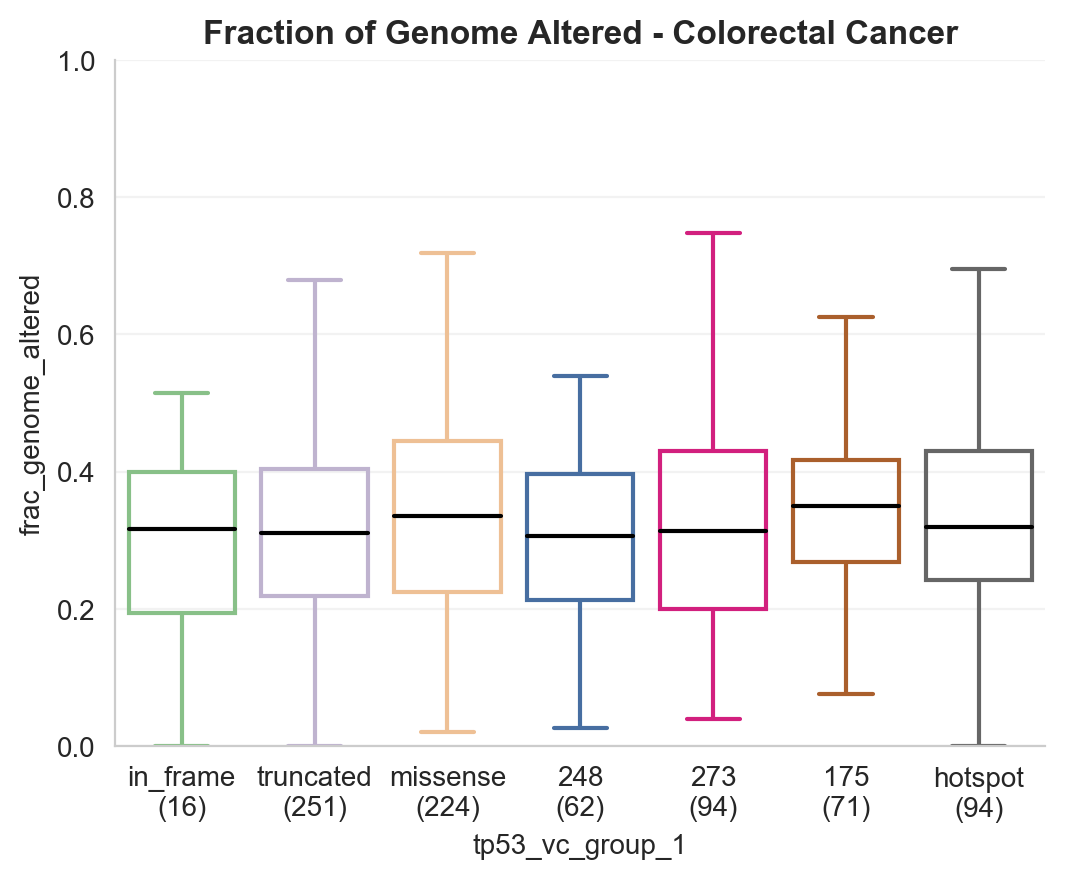

In [35]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='tp53_vc_group_1',
                  palette=mutation_palette,
                  order=mutation_list,
                  metrics='frac_genome_altered',
                  figsize=(6,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

### TP53 Residual Subgroups

In [36]:
print('Number of Bi Allelic samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'no_tp53_res'].shape[0]))
print('')
print('Number of  TP53 Residual samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'tp53_res'].shape[0]))



Number of Bi Allelic samples (with 1 mut): 708

Number of  TP53 Residual samples (with 1 mut): 92


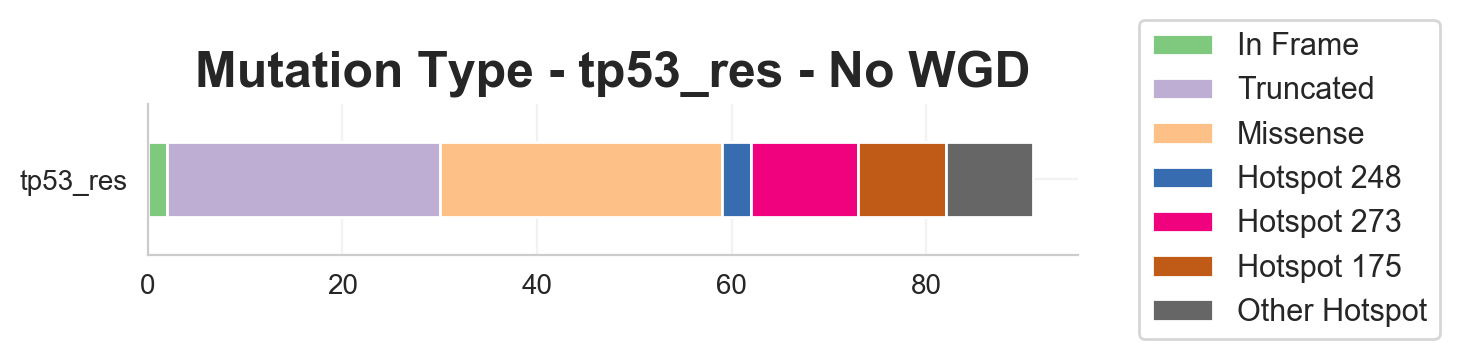

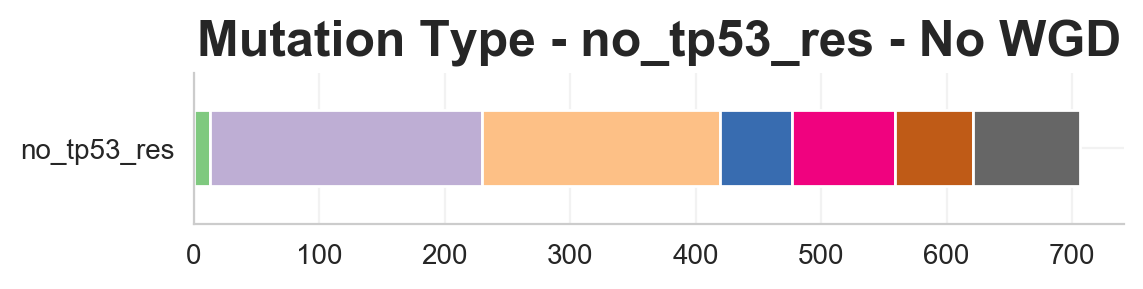

,tp53_res
tp53_vc_group_1,
missense,29
truncated,28
273,11
175,9
hotspot,9
248,3
in_frame,2
,no_tp53_res
tp53_vc_group_1,


In [37]:
total_df = []
for group in ['tp53_res', 'no_tp53_res']:
    h = get_groupby(master_hotspot[master_hotspot['tp53_res_group'] == group], 'tp53_vc_group_1', group).sort_values(by=group, ascending=False)
    total_df.append(h)
    
    h = h.T
    h = h[mutation_list]
    fig = plt.figure(figsize=(6,1))
    ax = plt.subplot()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
    if group == 'tp53_res':
        ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=11)
    else: ax.get_legend().remove()
    ax.set_title('Mutation Type - {} - No WGD'.format(group), weight='bold', fontsize=18)

    plt.show()

display_side_by_side(total_df[0],total_df[1])

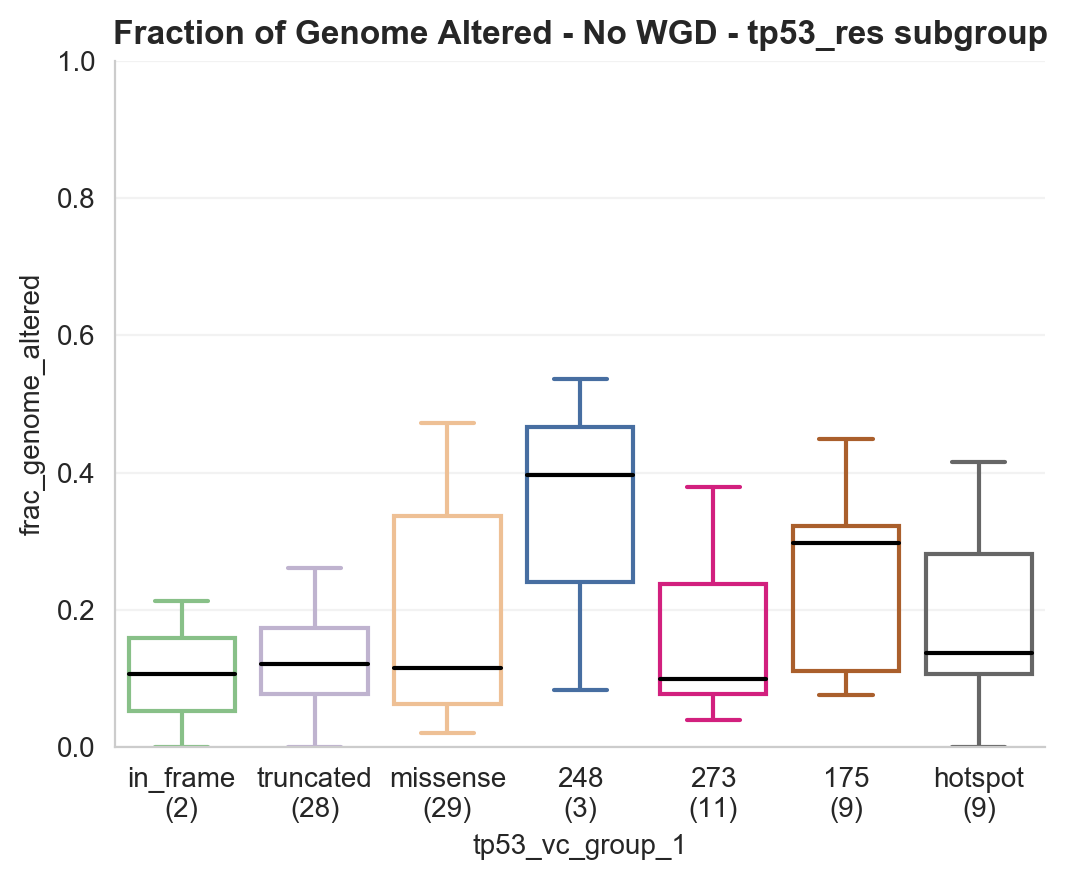

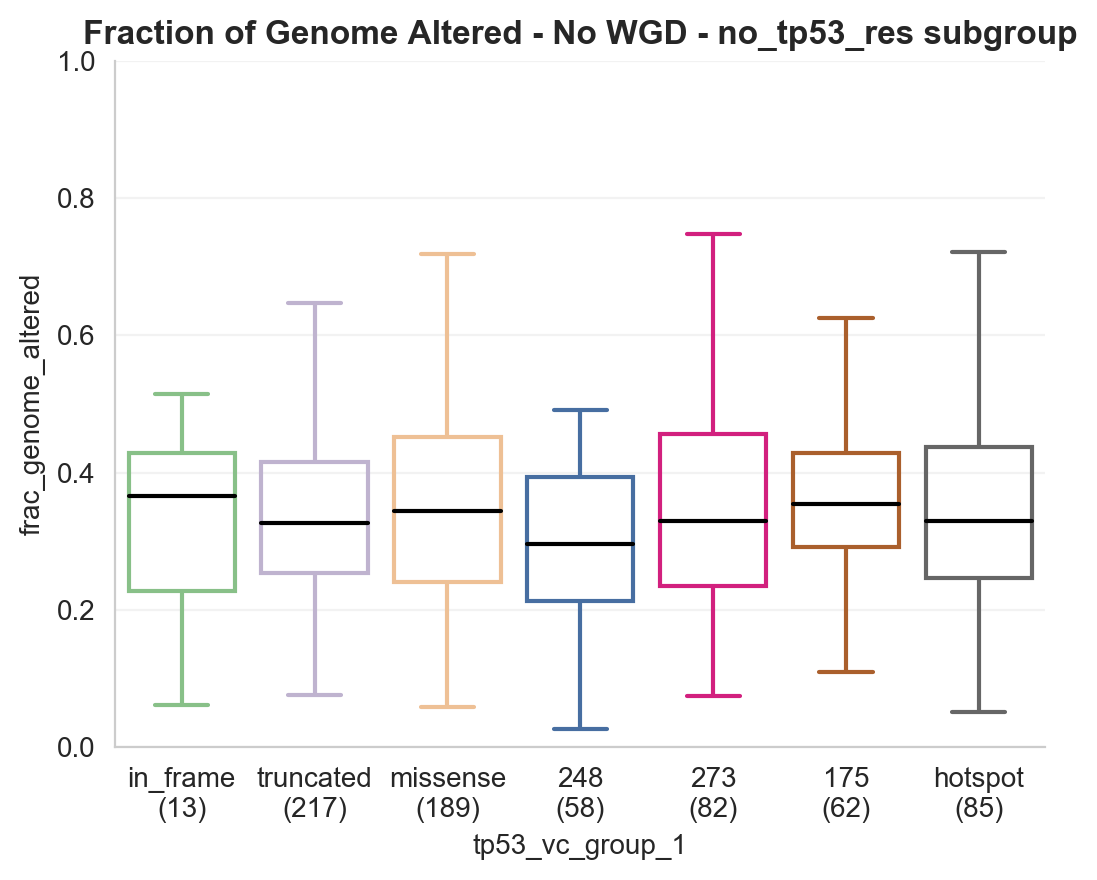

In [38]:
for group in ['tp53_res', 'no_tp53_res']:
    master_wt = master_hotspot[master_hotspot['tp53_res_group'] == group]

    fig, ax = boxplot_sampletype(df=master_wt,
                      group='tp53_vc_group_1',
                      palette=mutation_palette,
                      order=mutation_list,
                      metrics='frac_genome_altered',
                      figsize=(6,10),
                      title='Fraction of Genome Altered - No WGD - {} subgroup'.format(group),
                      xlim=[0,1])
    plt.show()

## SNV / INDEL Analysis
In this section we compare SNV and INDEL mutations. As in the previous section, we cut the cohort to keep only samples with exactly 1 tp53 mutation.

###  # of Drivers / SNV Drivers / INDEL Drivers 

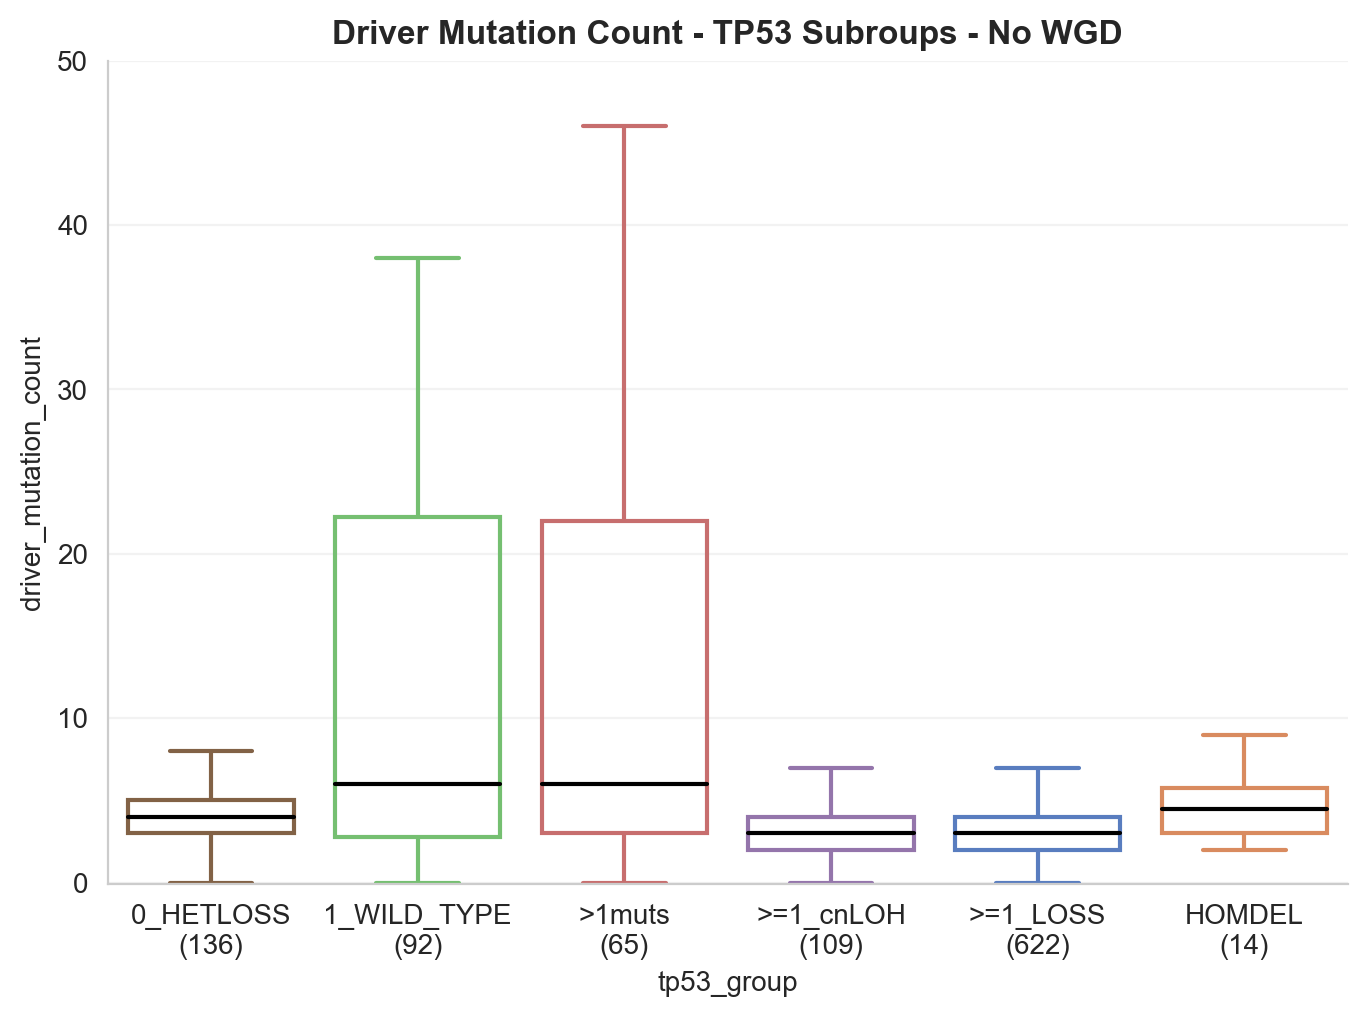

,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,92,6
2,0_HETLOSS,136,4
3,,Statistics,p-value
4,,3.39615,0.000683411
,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,92,6
2,>=1_LOSS,622,3
3,,Statistics,p-value


In [12]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='driver_mutation_count',
                  figsize=(8,12),
                  title='Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,50])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

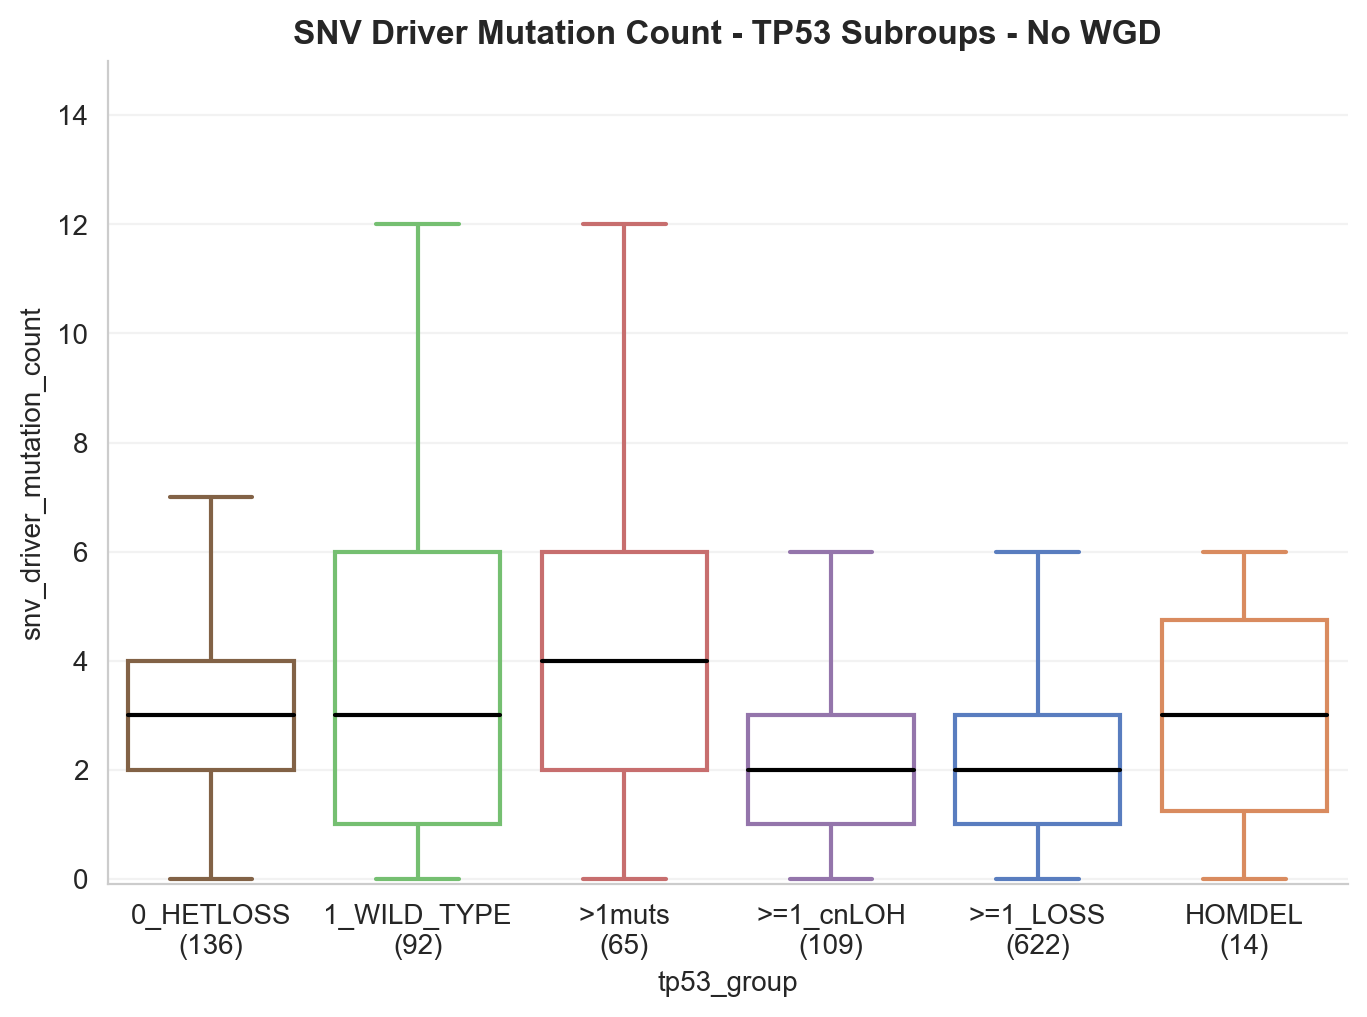

,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,92,3
2,0_HETLOSS,136,3
3,,Statistics,p-value
4,,1.82138,0.0685498
,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,92,3
2,>=1_LOSS,622,2
3,,Statistics,p-value


In [15]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='snv_driver_mutation_count',
                  figsize=(8,12),
                  title='SNV Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,15])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

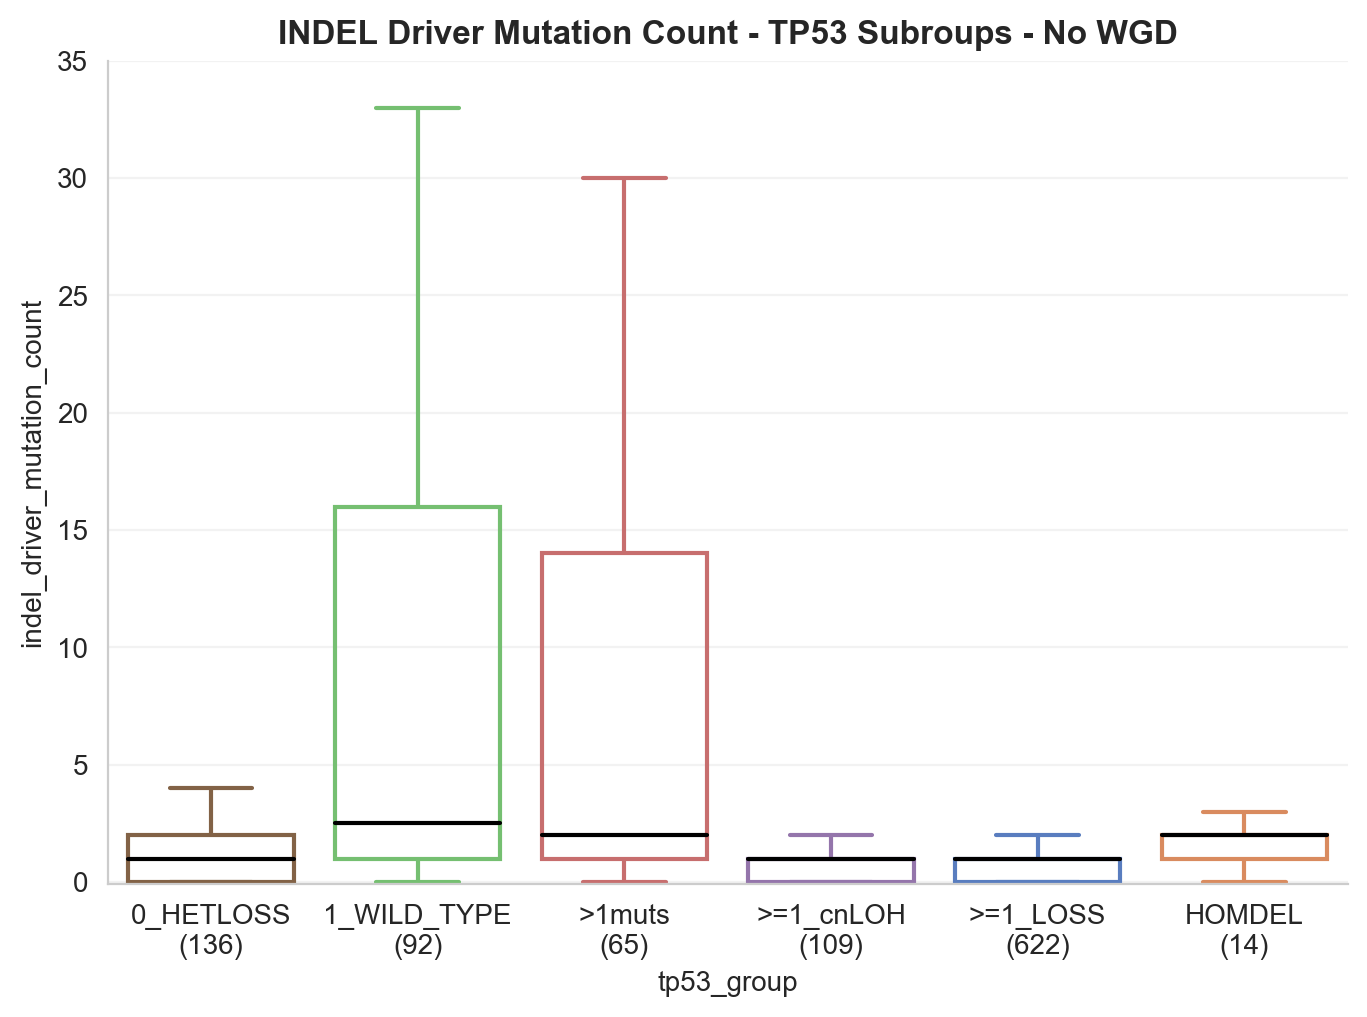

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,92,2.5
2,0_HETLOSS,136,1
3,,Statistics,p-value
4,,5.1019,3.36264e-07
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,92,2.5
2,>=1_LOSS,622,1
3,,Statistics,p-value


In [38]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='indel_driver_mutation_count',
                  figsize=(8,12),
                  title='INDEL Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,35])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

Here, two pieces of information:
* 1. In colorectal Cancer, *1_WILD_TYPE* is enriched in Driver Mutations in comparison with *0_HETLOSS* and even orther bi-allelic subgroups.
* 2.  This signal is led by INDEL Driver Mutation as we see that in SNV Driver Mutations, there is les significant differences between subgroups

### Genome Instability 
The idea here is to see if we have differences in Fraction of Genome Altered if we cut our Cancer cohort on the number of drivers per sample. 

Do we have more instability with more INDEL Driver Mutations within the same subgroup?

#### 1_WILD_TYPE Subgroup

In [37]:
master_no_wgd_cancer_wt = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '1_WILD_TYPE']

thr=6

def get_driver_groups(x):
    if x.driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_wt['co_driver_group'] = master_no_wgd_cancer_wt.apply(get_driver_groups, axis=1)

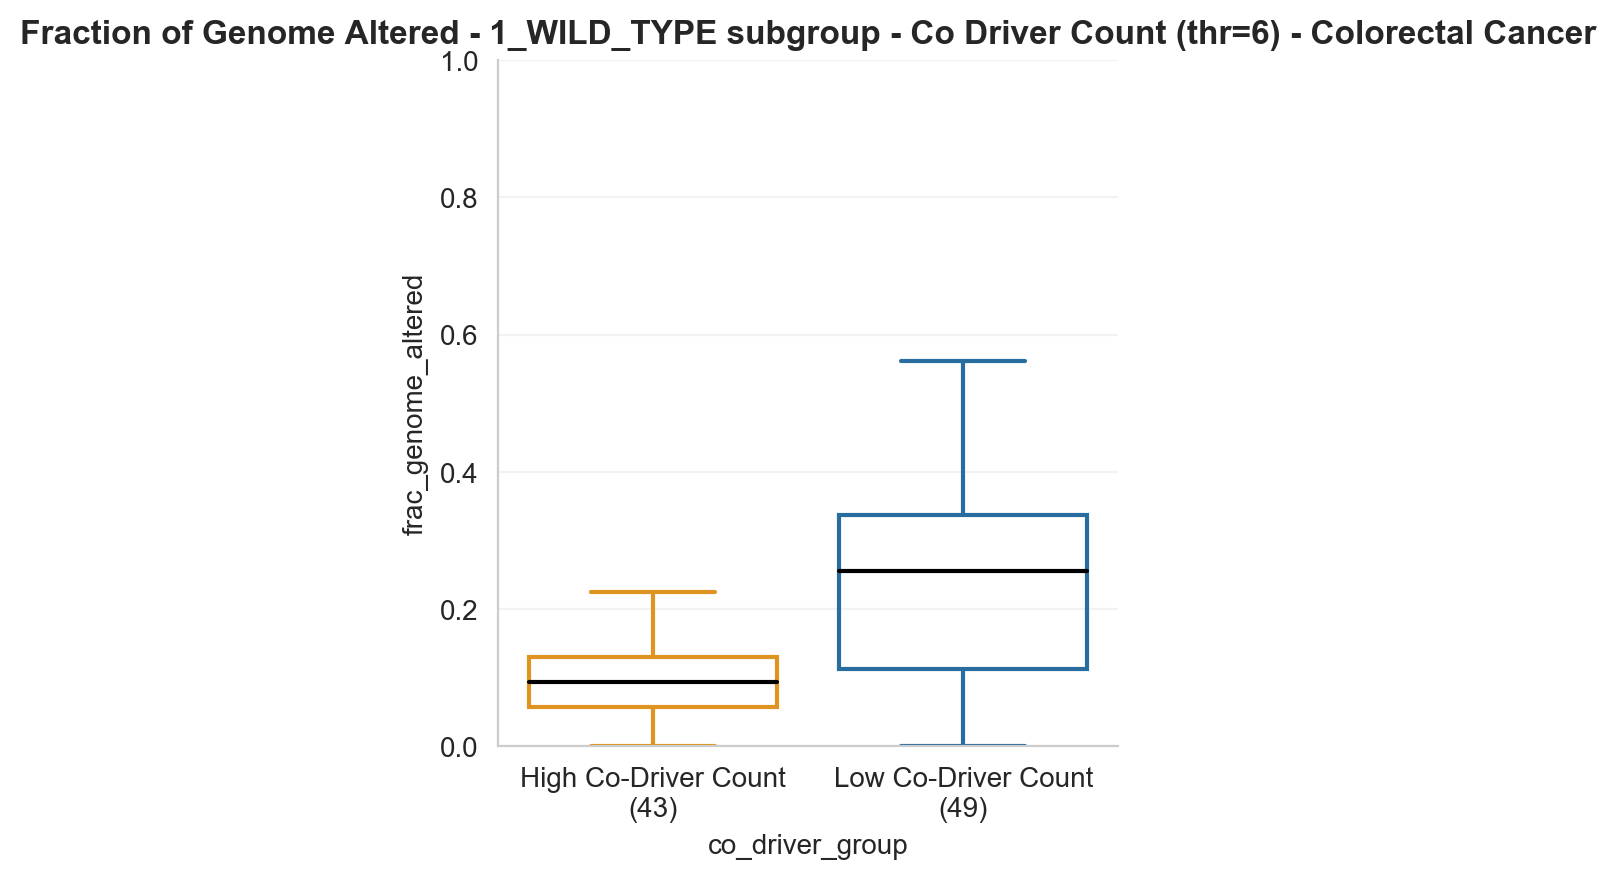

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,43,0.094
2,Low Co-Driver Count,49,0.256
3,,Statistics,p-value
4,,-4.55058,5.34987e-06


In [38]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

In [64]:
def plot_density(df: pd.DataFrame, xlabel='', ylabel='', title='',clip = (0,3), group = None,  figsize=(5,5)):
    sns.set_style("whitegrid", {'grid.color': '1.'})
    fig, ax = plt.subplots(figsize=figsize)
    
    
    data =df['tp53_ccf_1']
    ax = sns.distplot(data,kde_kws={'clip': clip, "shade": True}, hist=False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title('TP53 CCF for 1_WT in Non WGD Samples'  + title + ' (' + str(len(data)) + ')', weight = 'bold')
    
    mean=round(data.mean(),2) ; median=round(data.median(),2)
    string = 'Mean: '+ str(mean) +'\nMedian: ' + str(median)
    ax.axvline(mean, color='g', linestyle='-', label='Mean: '+ str(mean))
    ax.axvline(median, color='b', linestyle='-', label='Median: ' + str(median))
    ax.legend()
    #ax.set_xlim([0,1])
    
    plt.show()

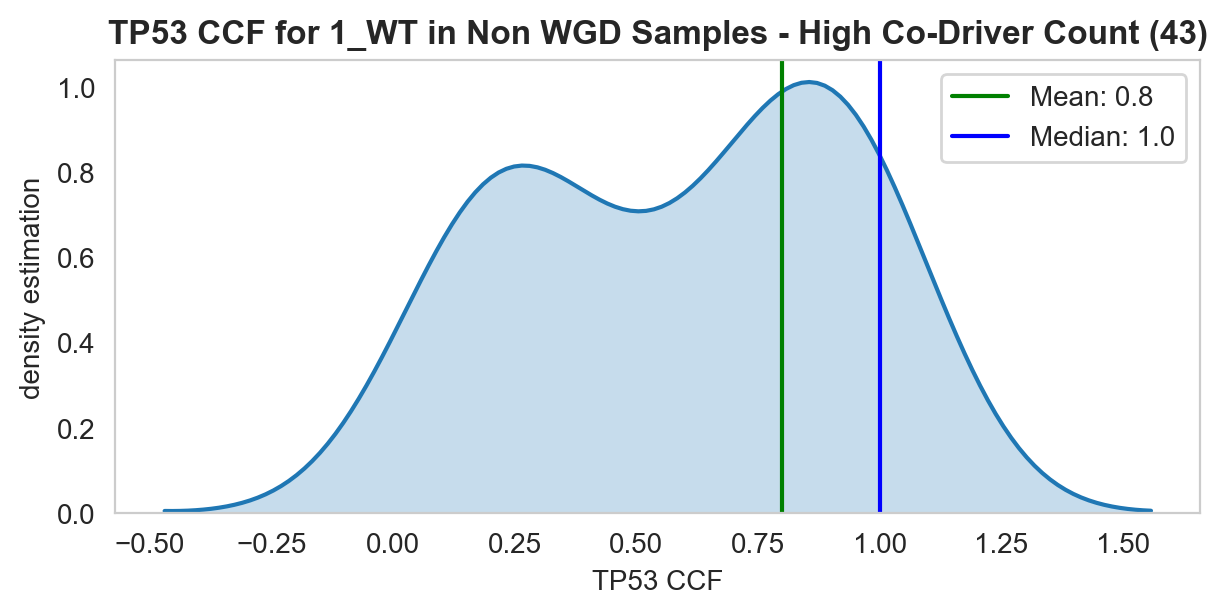

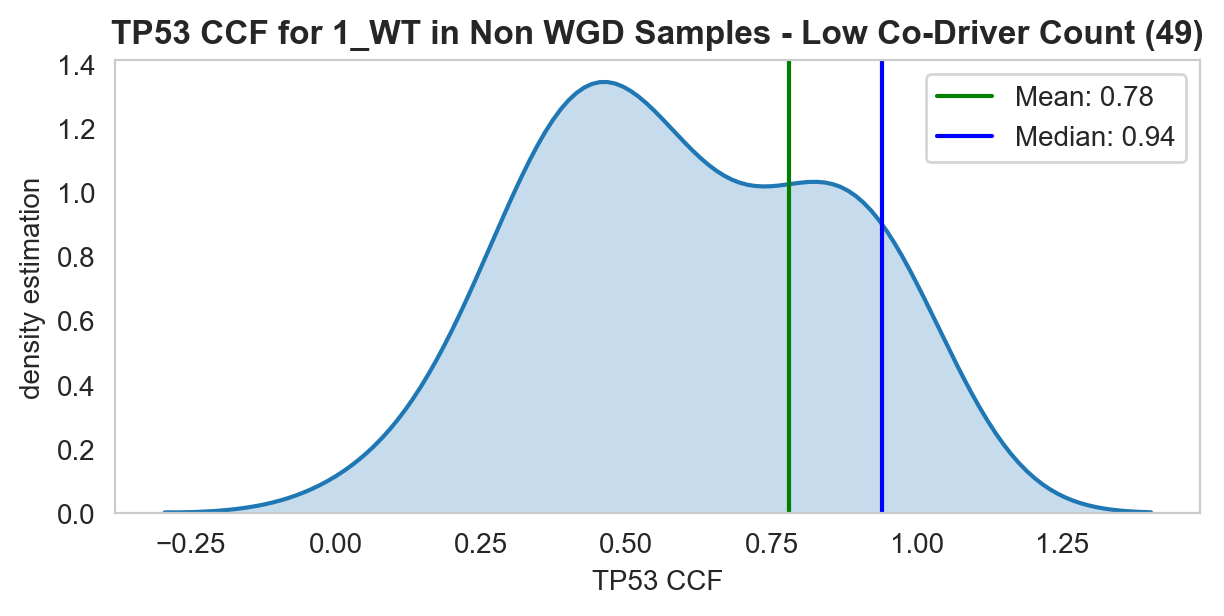

In [68]:
master_high_count = master_no_wgd_cancer_wt[master_no_wgd_cancer_wt['co_driver_group'] == 'High Co-Driver Count']
master_low_count = master_no_wgd_cancer_wt[master_no_wgd_cancer_wt['co_driver_group'] == 'Low Co-Driver Count']

plot_density(df=master_high_count,
             xlabel='TP53 CCF', 
             ylabel='density estimation',
             title=' - High Co-Driver Count',
             clip = (0,1), 
             group = None,  figsize=(7,3))
plt.show()

plot_density(df=master_low_count,
             xlabel='TP53 CCF', 
             ylabel='density estimation',
             title=' - Low Co-Driver Count',
             clip = (0,1), 
             group = None,  figsize=(7,3))

plt.show()

So we see that samples with less co-drivers have a higher Genome Instability

#### 0_HETLOSS

In [35]:
master_no_wgd_cancer_het = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '0_HETLOSS']

thr=0

def get_driver_groups(x):
    if x.indel_driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.indel_driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_het['co_driver_group'] = master_no_wgd_cancer_het.apply(get_driver_groups, axis=1)

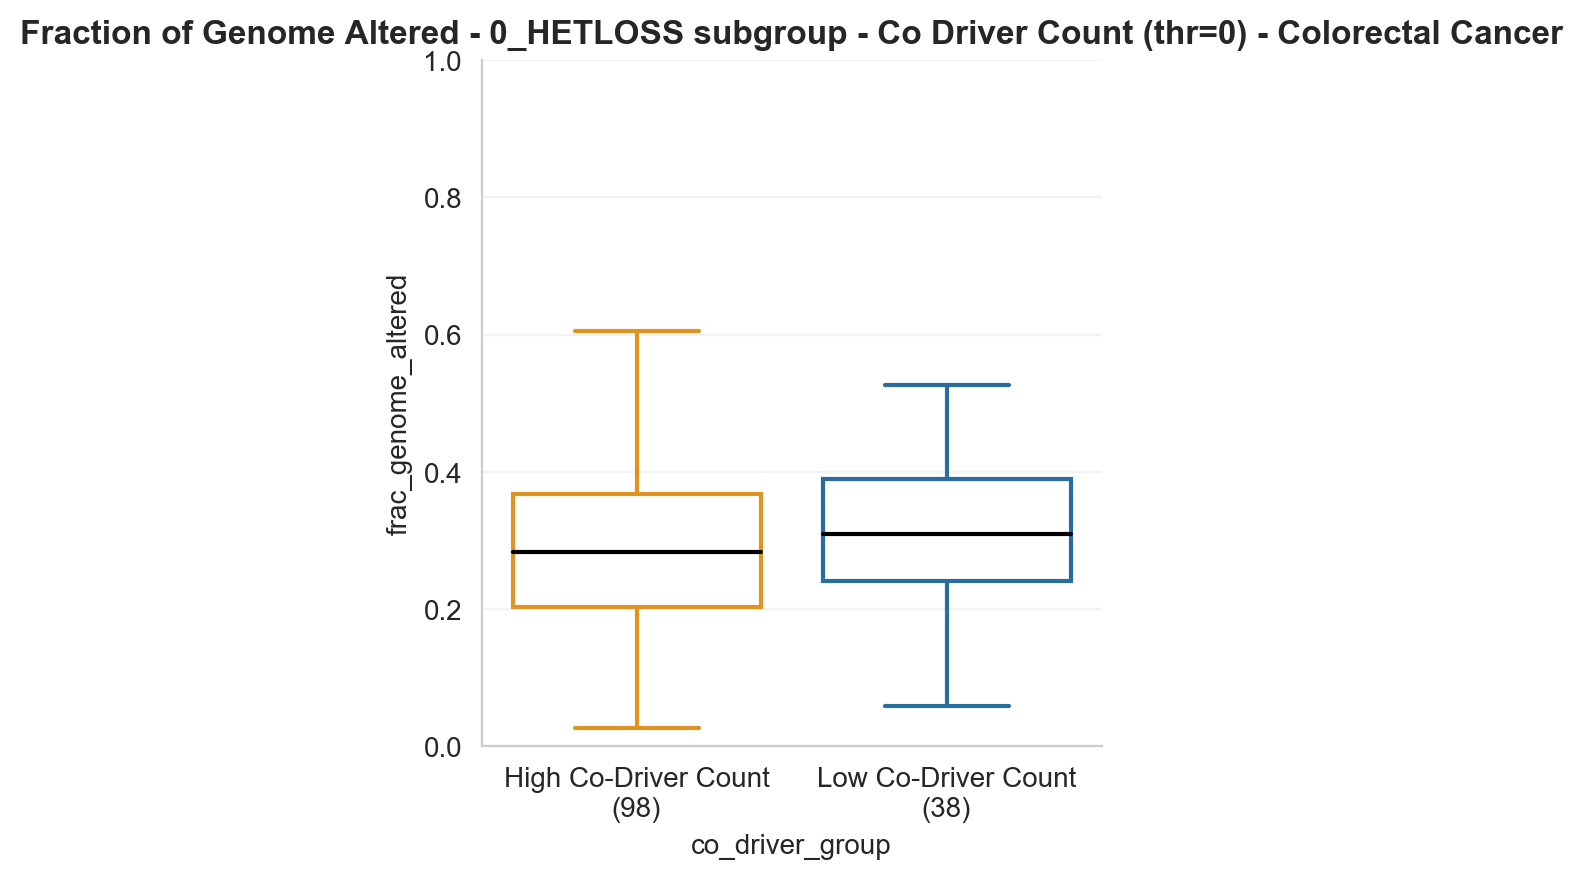

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,98,0.283
2,Low Co-Driver Count,38,0.3095
3,,Statistics,p-value
4,,-0.518931,0.603809


In [36]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_het,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 0_HETLOSS subgroup - INDEL Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_het,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

### Low CCF Analysis

In [11]:
thr_ccf_1 = 0.9

def ccf_subgroup(x):
    if x.tp53_ccf_1 <= thr_ccf_1: return 'low'
    elif x.tp53_ccf_1 > thr_ccf_1: return 'high'

master_no_wgd_cancer['ccf_group'] = master_no_wgd_cancer.apply(ccf_subgroup, axis=1)
get_groupby(master_no_wgd_cancer, 'ccf_group', 'count')

,count
ccf_group,
high,663
low,232


In [31]:
pd.DataFrame(master_no_wgd_cancer[['ccf_group', 'tp53_group']].groupby([ 'tp53_group', 'ccf_group']).size())

0
tp53_group  ccf_group     
1_WILD_TYPE high        53
            low         37
>1muts      high        34
            low         29
>=1_LOSS    high       492
            low        130
>=1_cnLOH   high        81
            low         28
HOMDEL      high         1
            low          6

In [16]:
master_no_wgd_cancer_low = master_no_wgd_cancer[(master_no_wgd_cancer['ccf_group'] == 'low') | (master_no_wgd_cancer['tp53_count'] == 0)]
get_groupby(master_no_wgd_cancer_low, 'tp53_group', 'count')

,count
tp53_group,
0_HETLOSS,136
1_WILD_TYPE,37
>1muts,29
>=1_LOSS,130
>=1_cnLOH,28
HOMDEL,12


#### # of Drivers 

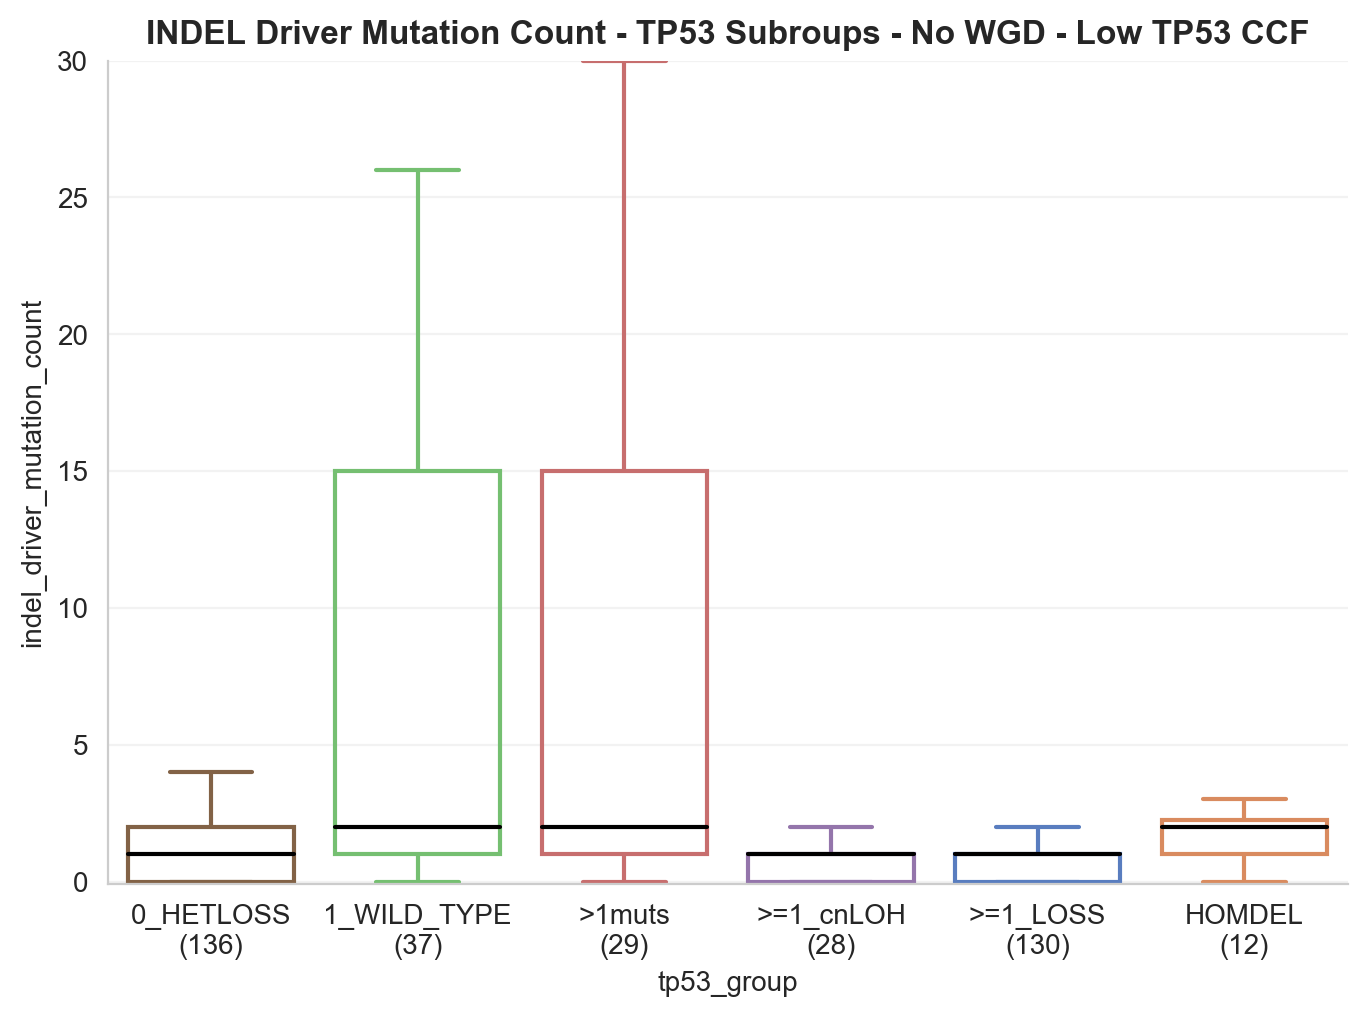

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,37,2
2,0_HETLOSS,136,1
3,,Statistics,p-value
4,,3.18934,0.00142598
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,37,2
2,>=1_LOSS,130,1
3,,Statistics,p-value


In [36]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_low,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='indel_driver_mutation_count',
                  figsize=(8,12),
                  title='INDEL Driver Mutation Count - TP53 Subroups - No WGD - Low TP53 CCF',
                  xlim=[-0.1,30])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer_low,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer_low,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer_low,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

#### GI in 1_WILD_TYPE

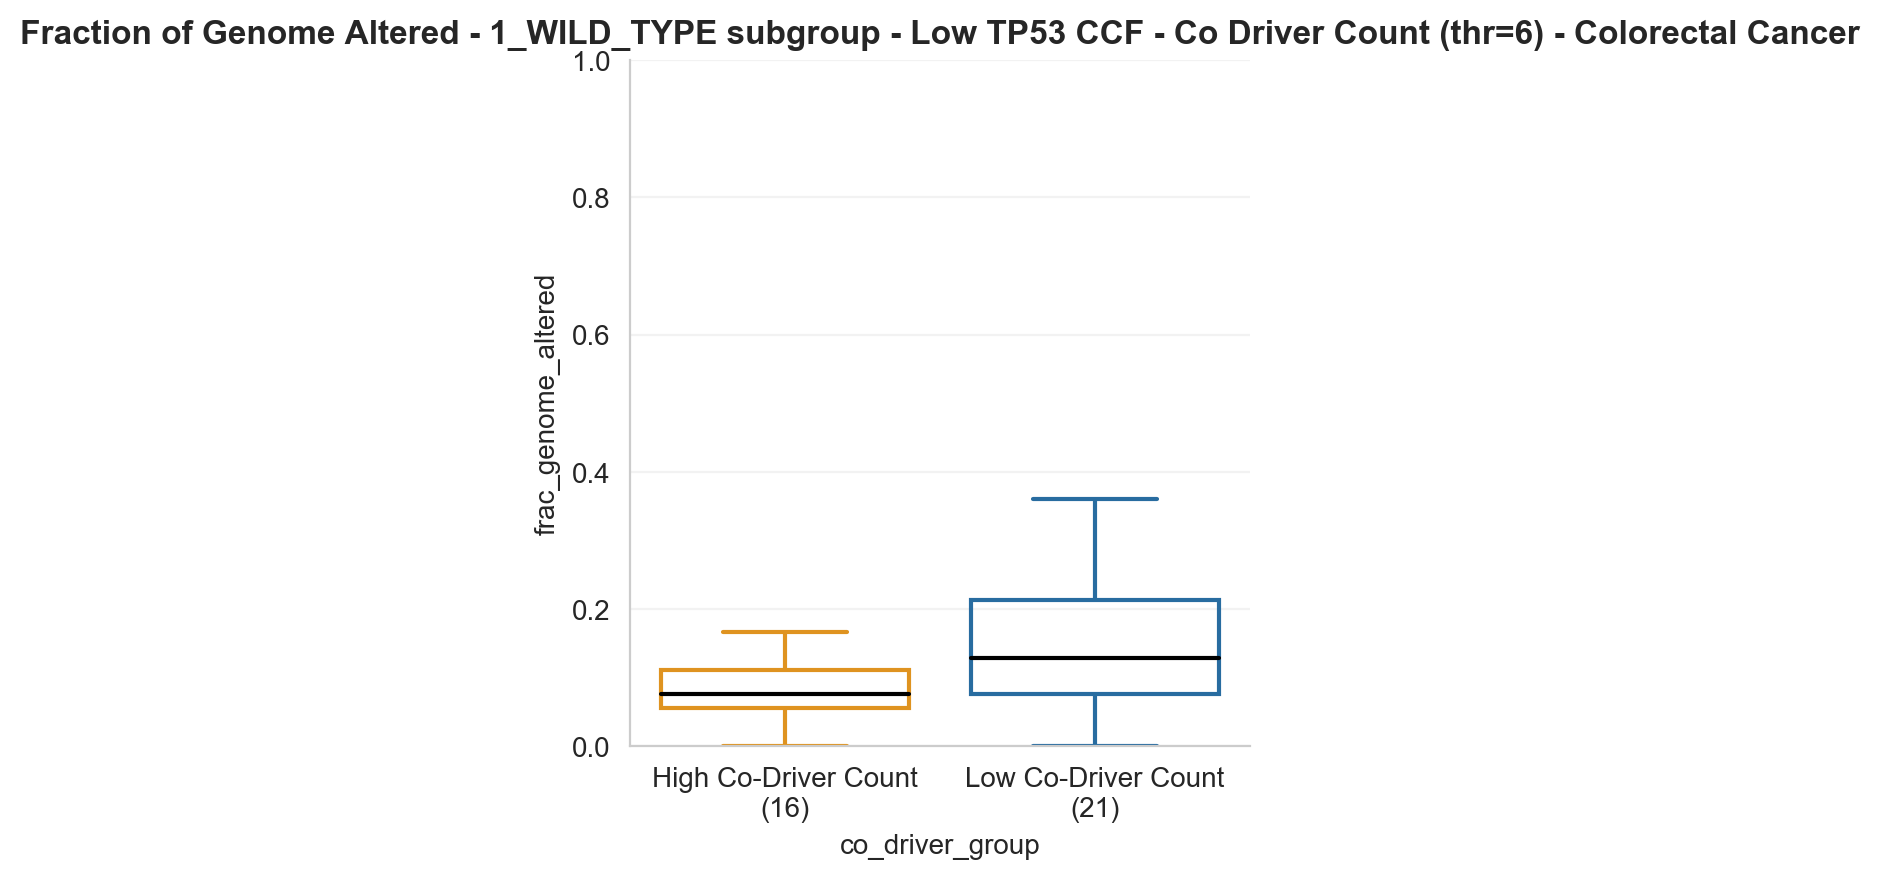

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,16,0.076
2,Low Co-Driver Count,21,0.128
3,,Statistics,p-value
4,,-1.83942,0.0658537


In [32]:
master_no_wgd_cancer_low_wt = master_no_wgd_cancer_low[master_no_wgd_cancer_low['tp53_group'] == '1_WILD_TYPE']

thr=6

def get_driver_groups(x):
    if x.driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_low_wt['co_driver_group'] = master_no_wgd_cancer_low_wt.apply(get_driver_groups, axis=1)

fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_low_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - Low TP53 CCF - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_low_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

### High CCF Analysis

In [26]:
master_no_wgd_cancer_high = master_no_wgd_cancer[(master_no_wgd_cancer['ccf_group'] == 'high') | (master_no_wgd_cancer['tp53_count'] == 0)]
get_groupby(master_no_wgd_cancer_high, 'tp53_group', 'count')

,count
tp53_group,
0_HETLOSS,136
1_WILD_TYPE,53
>1muts,34
>=1_LOSS,492
>=1_cnLOH,81
HOMDEL,7


#### # of Drivers  

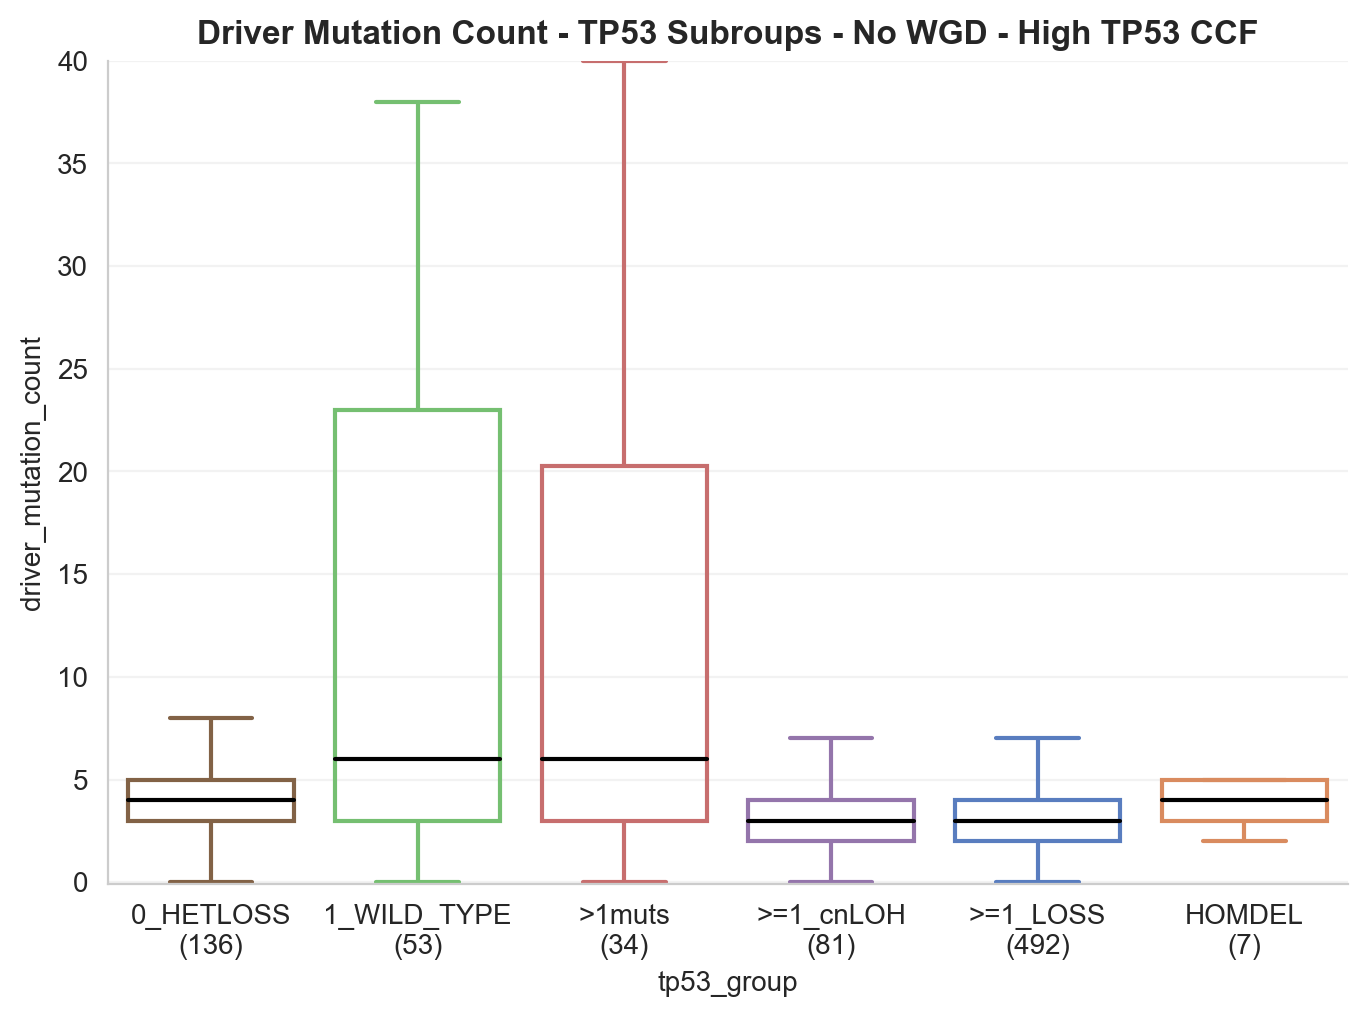

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,53,4
2,0_HETLOSS,136,1
3,,Statistics,p-value
4,,4.63256,3.61177e-06
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,53,4
2,>=1_LOSS,492,1
3,,Statistics,p-value


In [47]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_high,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='driver_mutation_count',
                  figsize=(8,12),
                  title='Driver Mutation Count - TP53 Subroups - No WGD - High TP53 CCF',
                  xlim=[-0.1,40])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer_high,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer_high,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer_high,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

#### GI in 1_WILD_TYPE

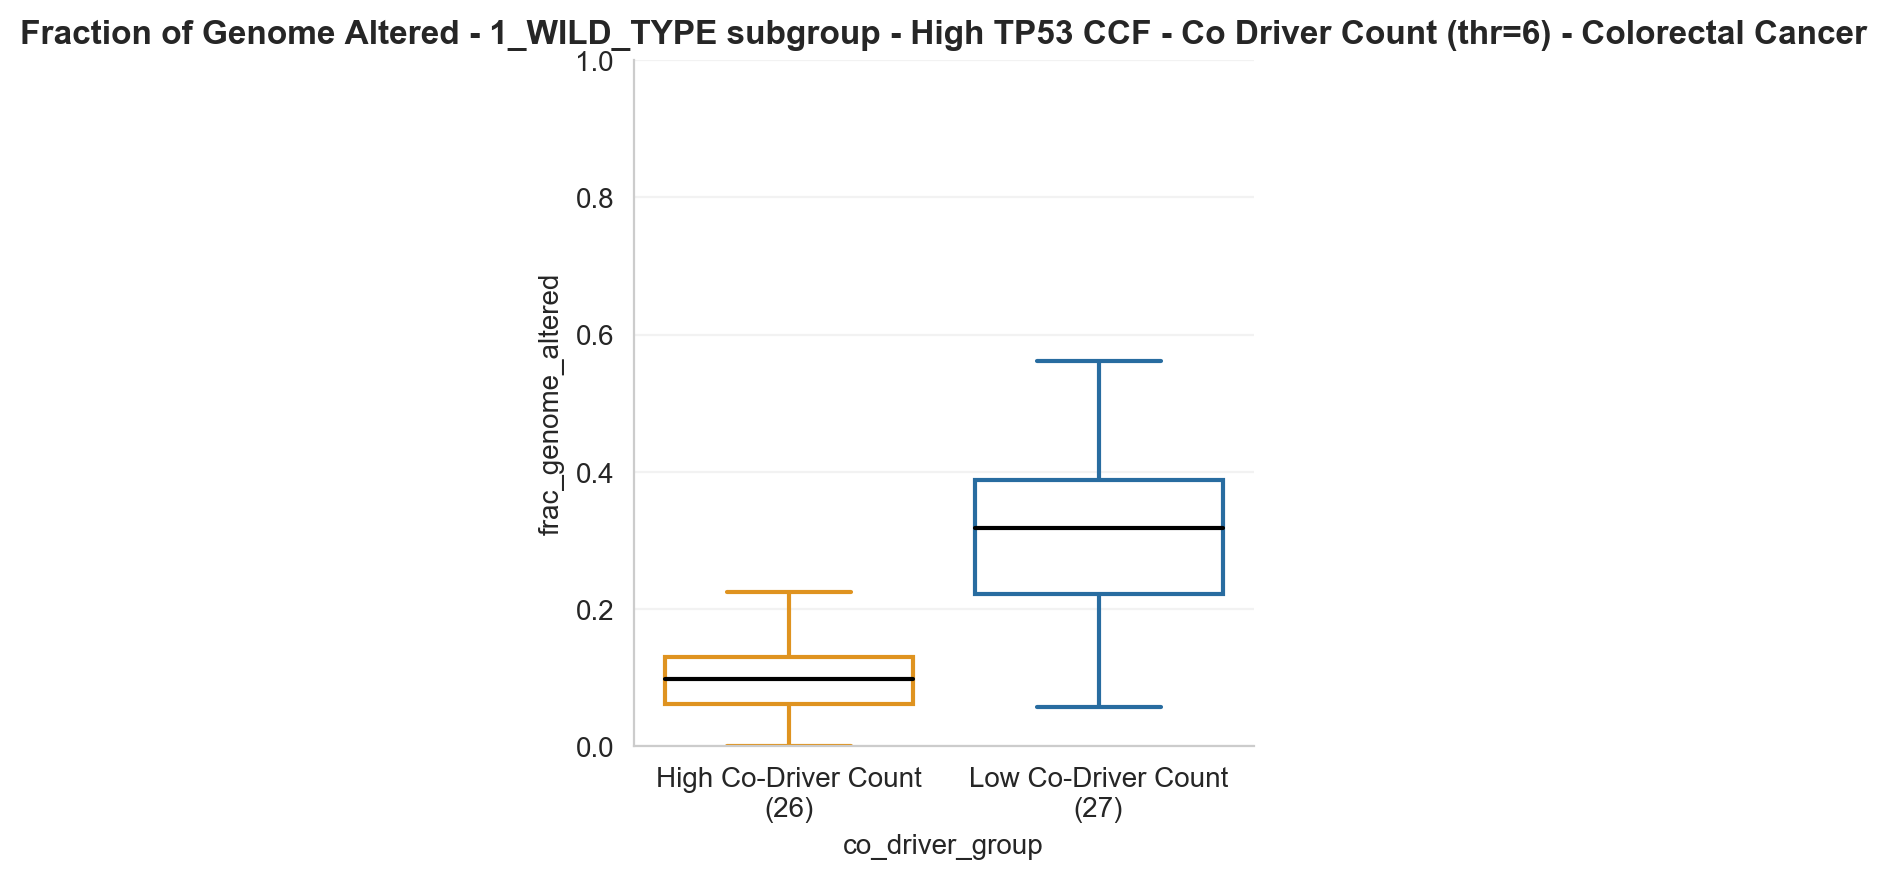

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,26,0.098
2,Low Co-Driver Count,27,0.318
3,,Statistics,p-value
4,,-4.86612,1.13812e-06


In [28]:
master_no_wgd_cancer_high_wt = master_no_wgd_cancer_high[master_no_wgd_cancer_high['tp53_group'] == '1_WILD_TYPE']

thr=6

def get_driver_groups(x):
    if x.driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_high_wt['co_driver_group'] = master_no_wgd_cancer_high_wt.apply(get_driver_groups, axis=1)

fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_high_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - High TP53 CCF - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_high_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

## CCF / VAF Analysis
Same here we take only samples with exactly 1 tp53 mutation (*master_hotspot*).

We have to define groups for CCF to see if there are differences between those groups. To have an idea of the CCF distribution we show here the distribution coming from the *cancer_panel*.

<img src="colorectal_ccf.png" width=1000 length=1000>

We see that our tp53_ccf distribution is very high for all subgroups. *>=1_LOSS* is the biggest subgroup - by far - and has a very high CCF median.

It will be hard to cut the cohort based on the CCF. Let's try and see the size of the subcohorts:

In [70]:
master_ccf = master_no_wgd_cancer[(master_no_wgd_cancer['tp53_count'] == 1) | (master_no_wgd_cancer['tp53_group'] == '0_HETLOSS')]

In [71]:
thr_ccf_1 = 0.8 ; thr_ccf_2 = 0.9

def ccf_subgroup(x):
    if x.tp53_ccf_1 <= thr_ccf_1: return 'low'
    elif x.tp53_ccf_1 <= thr_ccf_2: return 'medium'
    elif x.tp53_ccf_1 > thr_ccf_2: return 'high'

master_ccf['ccf_group'] = master_ccf.apply(ccf_subgroup, axis=1)
get_groupby(master_ccf, 'ccf_group', 'count')

,count
ccf_group,
high,624
low,90
medium,98


In [72]:
thr_vaf_1 = 0.3 ; thr_vaf_2 = 0.4

def vaf_subgroup(x):
    if x.tp53_vaf_1 <= thr_vaf_1: return 'low'
    elif x.tp53_vaf_1 <= thr_vaf_2: return 'medium'
    elif x.tp53_vaf_1 > thr_vaf_2: return 'high'

master_ccf['vaf_group'] = master_ccf.apply(vaf_subgroup, axis=1)       
get_groupby(master_ccf, 'vaf_group', 'count')

,count
vaf_group,
high,249
low,409
medium,157


### VAF Analysis

#### No VAF Cut

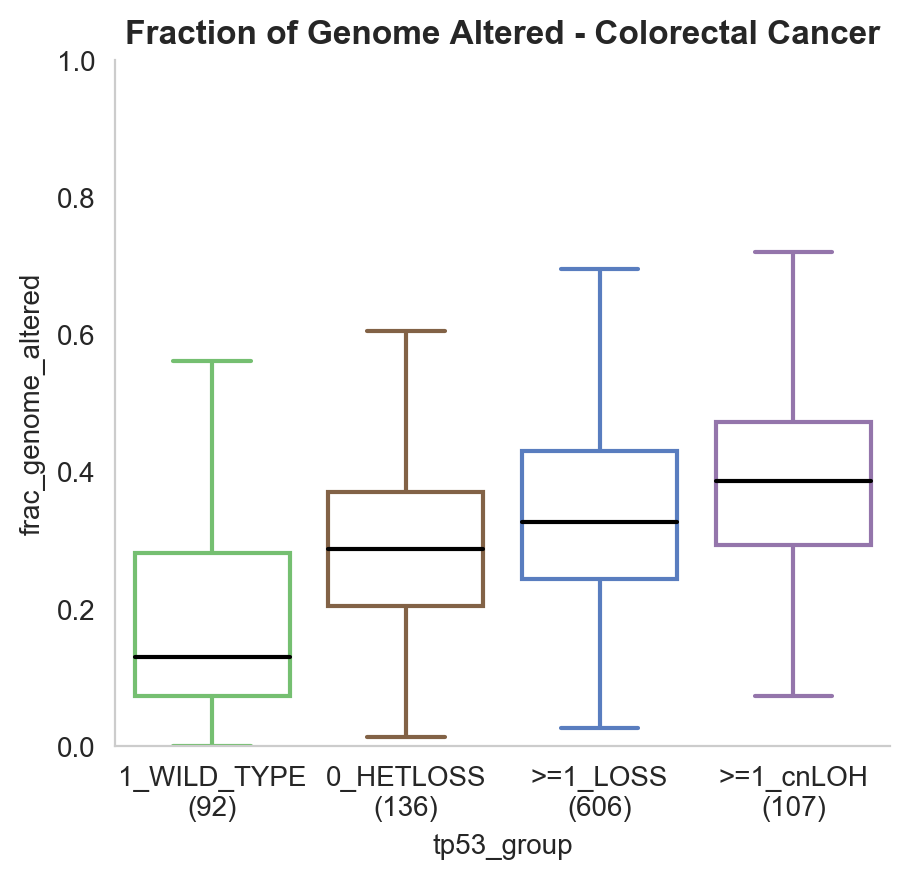

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,136,0.2875
2,1_WILD_TYPE,92,0.1295
3,,Statistics,p-value
4,,6.06375,1.32985e-09


In [76]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low VAF

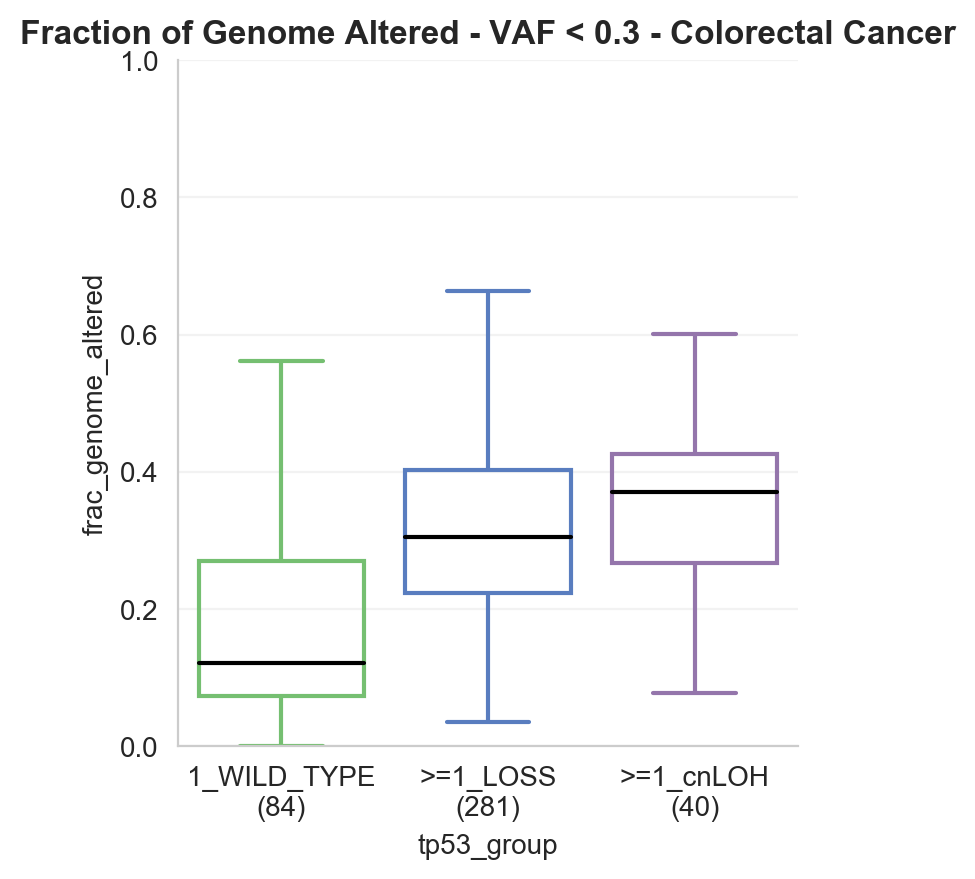

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,84,0.1215
2,>=1_LOSS,281,0.305
3,,Statistics,p-value
4,,-8.15338,3.53883e-16


In [90]:
master_low = master_hotspot[master_hotspot['vaf_group'] == 'low']

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - VAF < {} - {}'.format(thr_vaf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '>=1_LOSS'])

#### Medium VAF

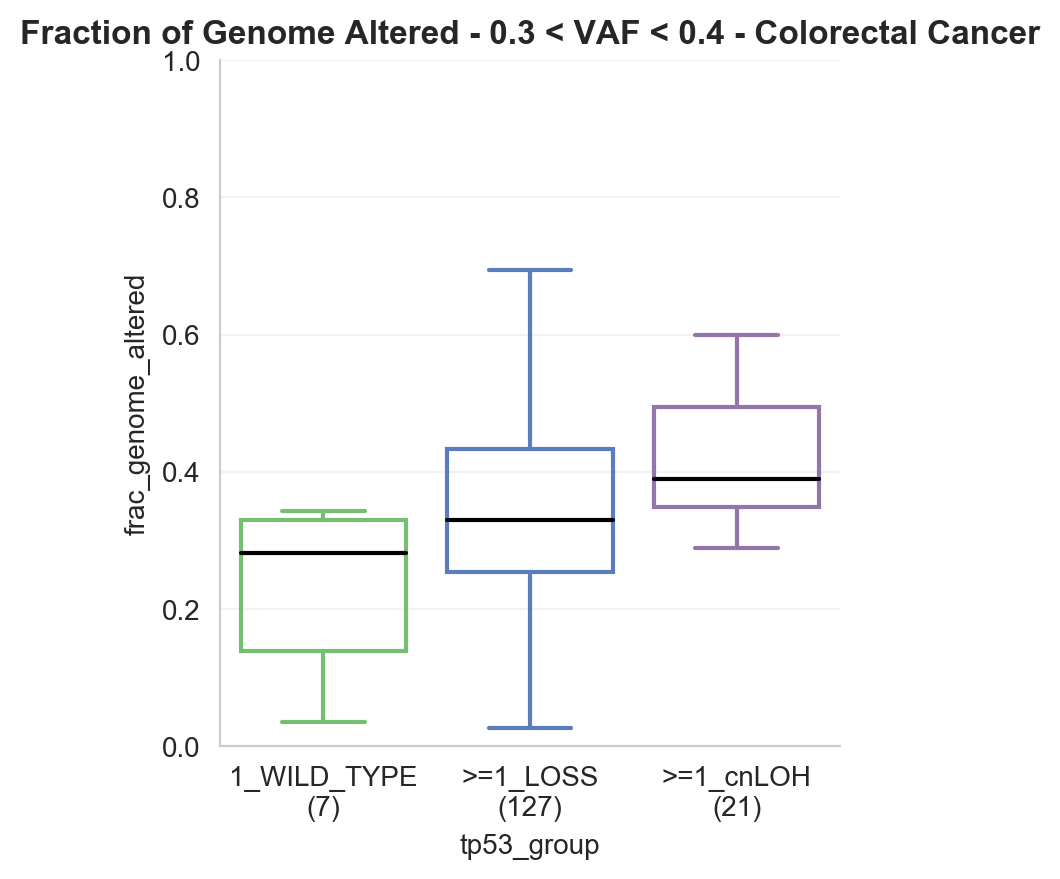

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,7,0.281
2,>=1_LOSS,127,0.33
3,,Statistics,p-value
4,,-1.77989,0.0750942


In [88]:
master_med = master_hotspot[master_hotspot['vaf_group'] == 'medium']

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - {} < VAF < {} - {}'.format(thr_vaf_1,thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '>=1_LOSS'])

#### High VAF

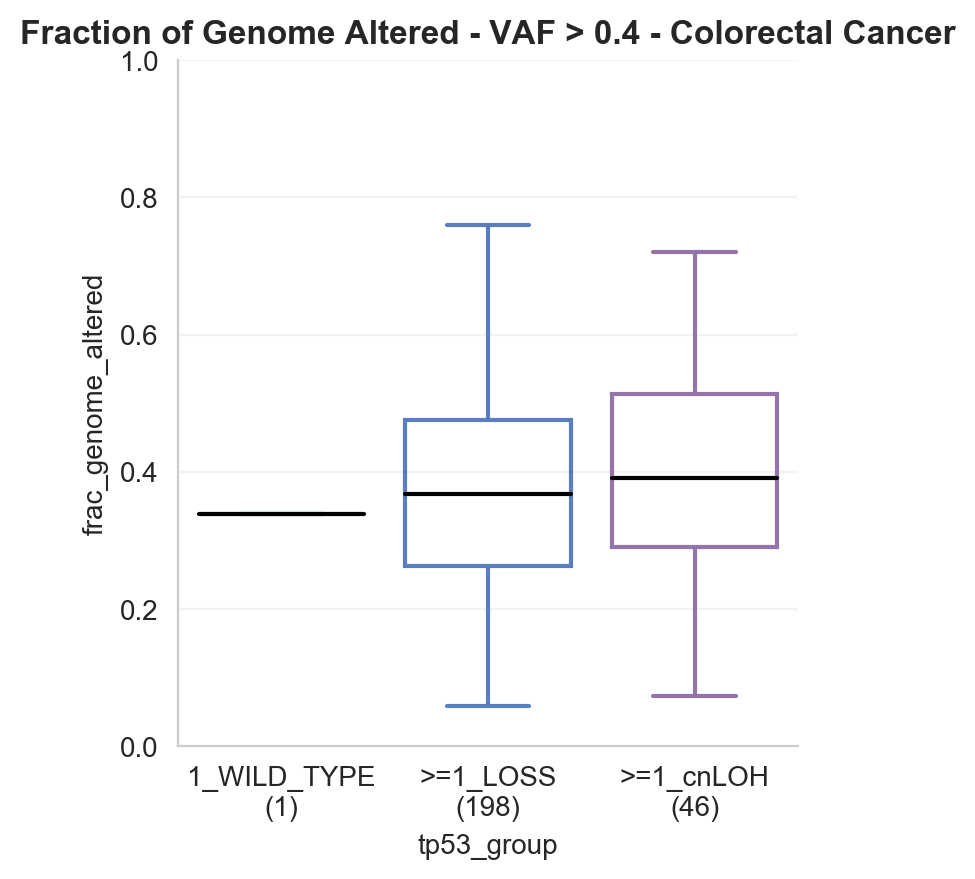

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,1,0.338
2,>=1_LOSS,198,0.3675
3,,Statistics,p-value
4,,-0.243709,0.807456


In [89]:
master_high = master_hotspot[master_hotspot['vaf_group'] == 'high']

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - VAF > {} - {}'.format(thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '>=1_LOSS'])

### CCF Analysis

#### No CCF Cut

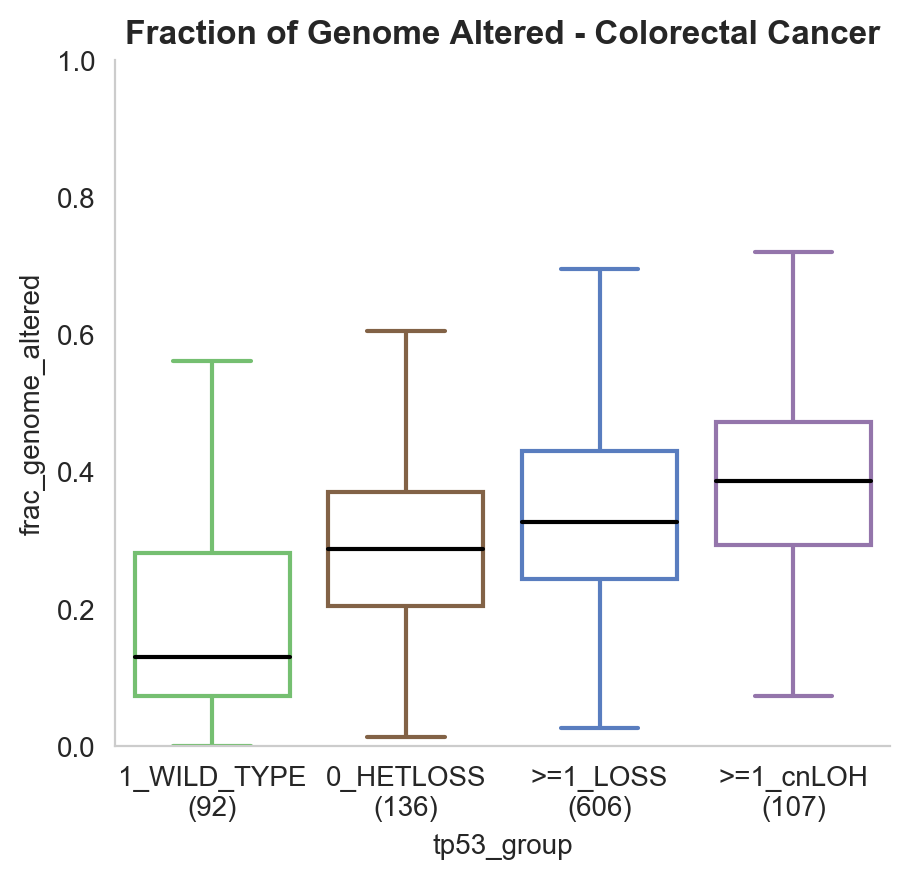

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,136,0.2875
2,1_WILD_TYPE,92,0.1295
3,,Statistics,p-value
4,,6.06375,1.32985e-09


In [80]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low CCF

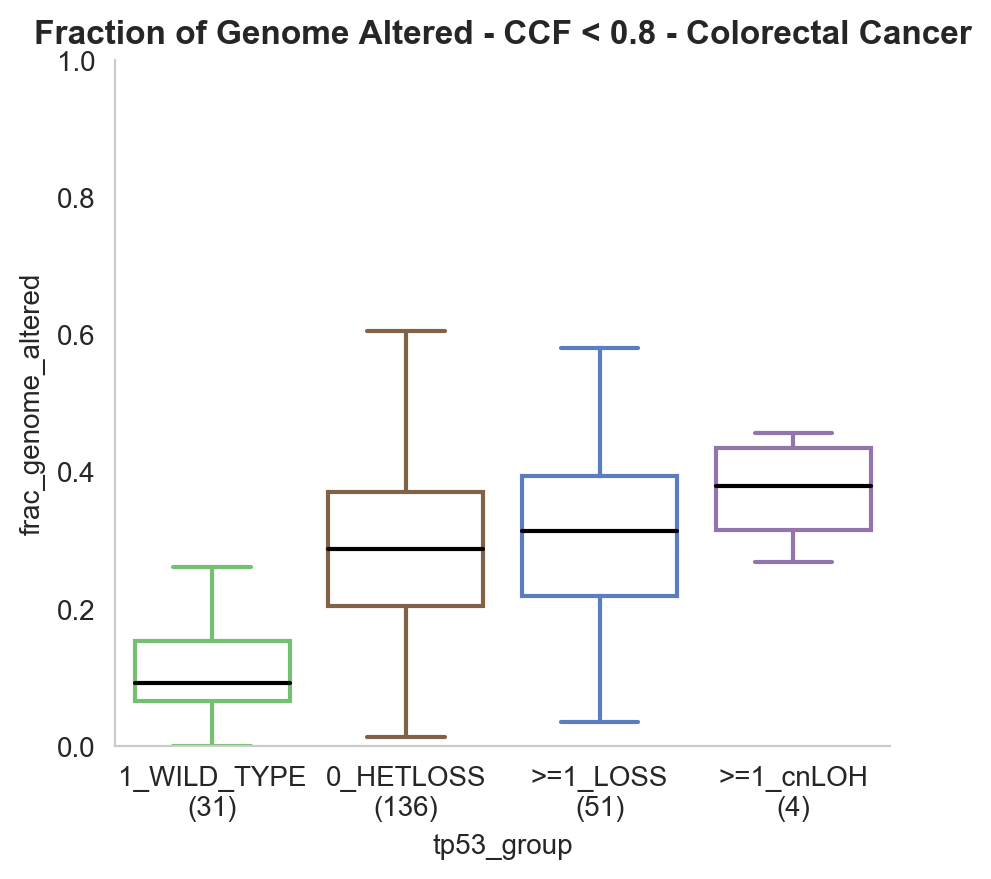

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,31,0.092
2,0_HETLOSS,136,0.2875
3,,Statistics,p-value
4,,-6.28734,3.22953e-10


In [84]:
master_low = master_ccf[(master_ccf['ccf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF < {} - {}'.format(thr_ccf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### Medium CCF

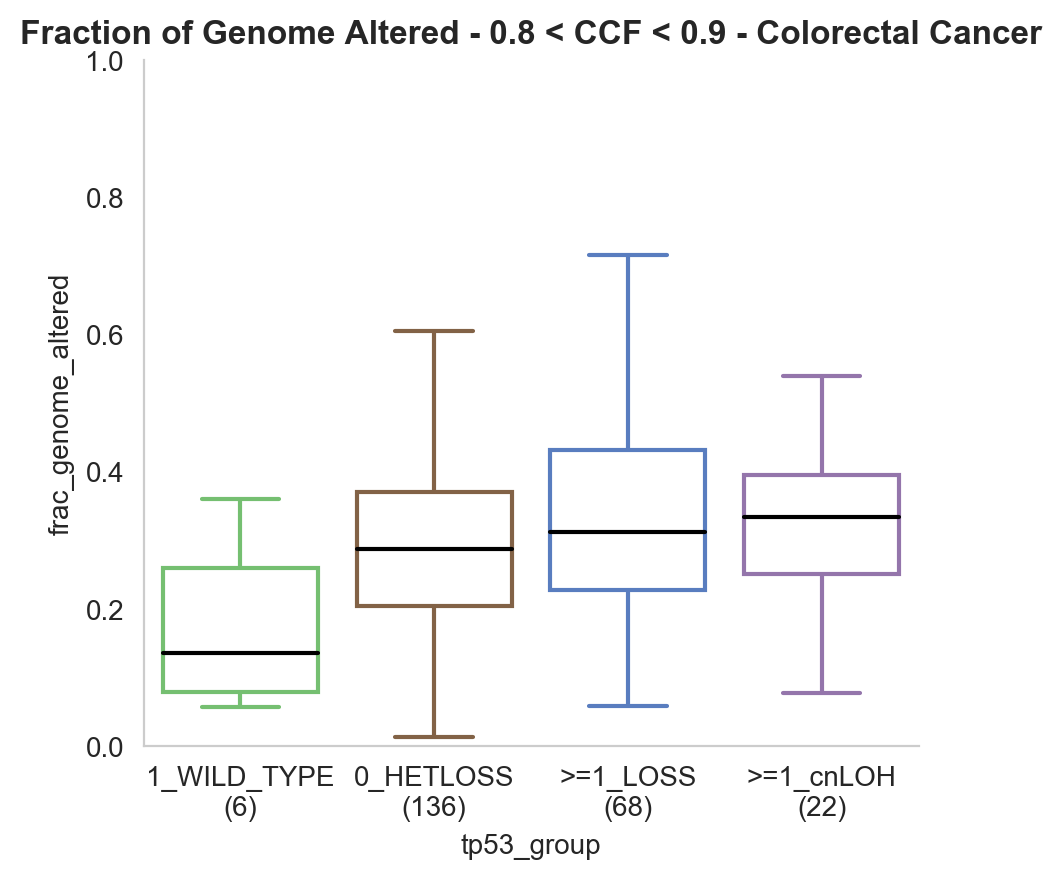

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,6,0.136
2,0_HETLOSS,136,0.2875
3,,Statistics,p-value
4,,-1.98762,0.0468536


In [89]:
master_med = master_ccf[(master_ccf['ccf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < CCF < {} - {}'.format(thr_ccf_1,thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High CCF

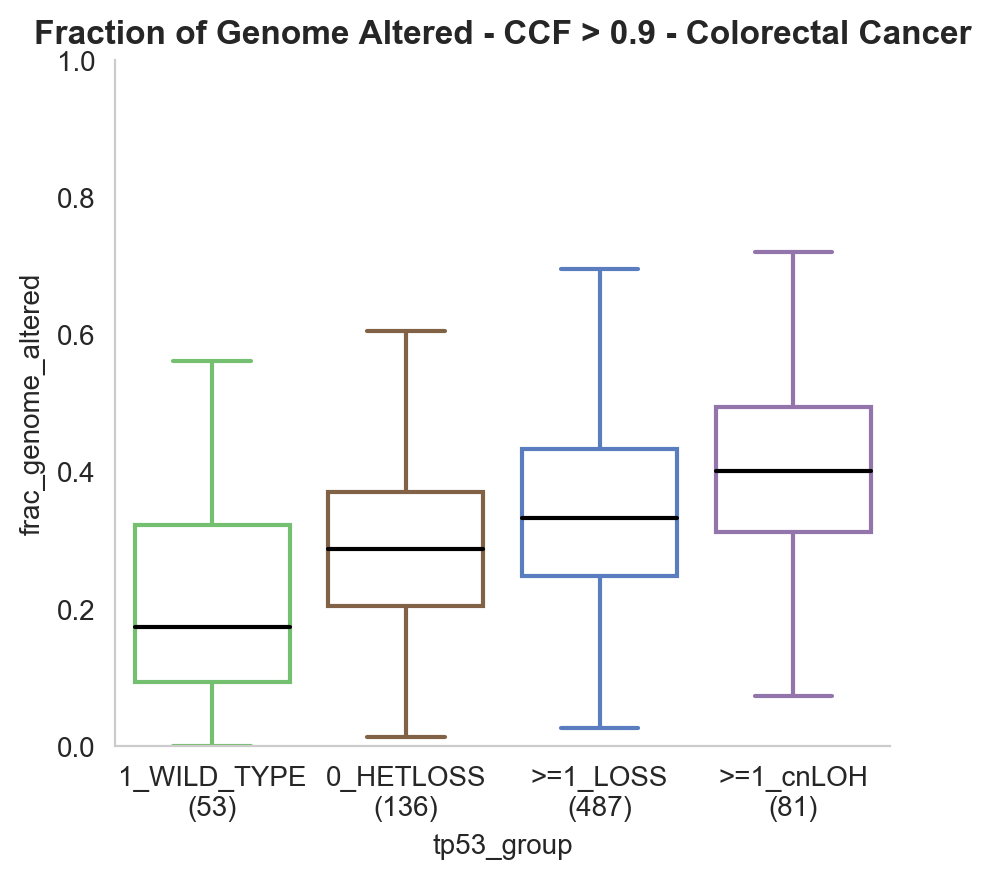

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,53,0.174
2,0_HETLOSS,136,0.2875
3,,Statistics,p-value
4,,-3.67792,0.000235139


In [91]:
master_high = master_ccf[(master_ccf['ccf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF > {} - {}'.format(thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### Splitting on the different level of CCF / VAF

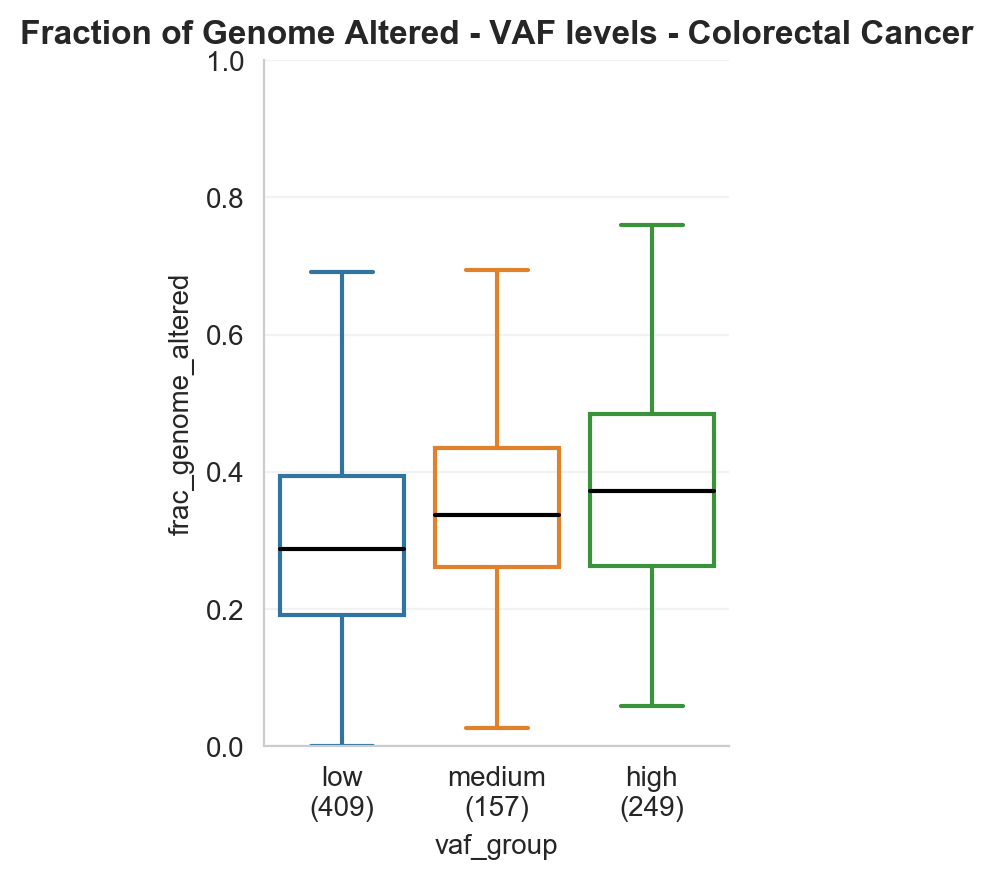

,0,1,2
0,,size,frac_genome_altered
1,low,409,0.288
2,medium,157,0.337
3,,Statistics,p-value
4,,-4.14385,3.41517e-05


In [96]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='vaf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - VAF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='vaf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

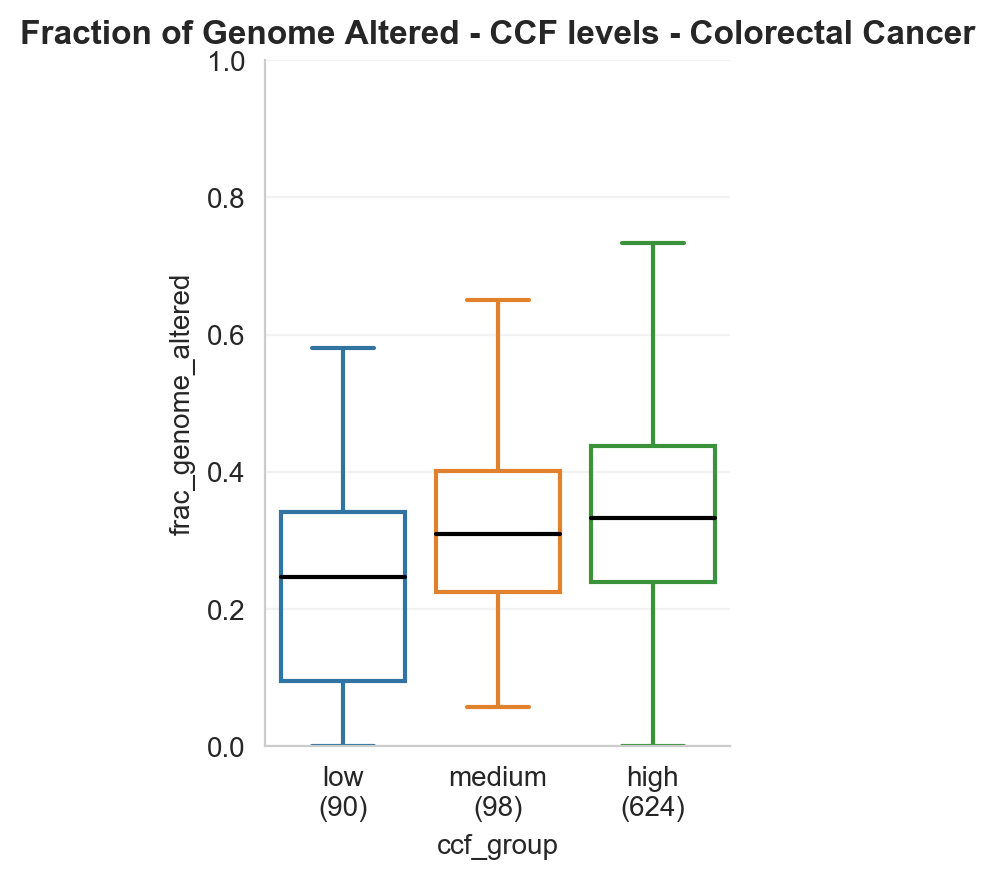

,0,1,2
0,,size,frac_genome_altered
1,low,90,0.2465
2,medium,98,0.31
3,,Statistics,p-value
4,,-3.60197,0.000315819


In [121]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='ccf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - CCF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='ccf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

## Clinical Correlates

### Age

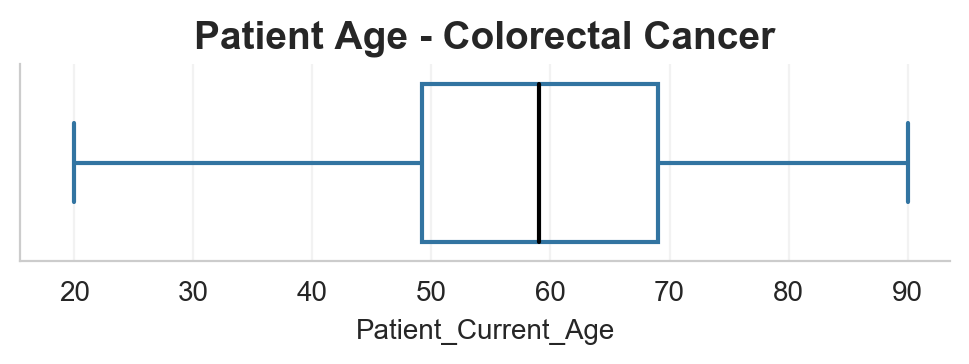

In [120]:
#fig=plt.figure(figsize=(10,3))
ax = plt.subplot2grid(shape=(4,1), loc=(0,0), colspan=1)

sns.boxplot(x='Patient_Current_Age',data=master_no_wgd_cancer, ax=ax).set_title('Patient Age - {}'.format(cancer), weight='bold', fontsize=14)


style(ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Sex

,count
Sex,
Male,762
Female,684


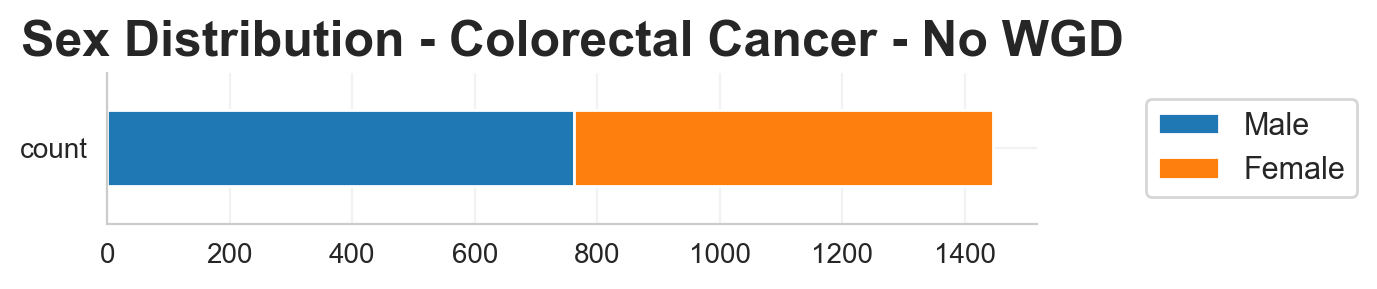

In [129]:
h = get_groupby(master_no_wgd_cancer,'Sex', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[['Male', 'Female']]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax)
ax.legend(['Male', 'Female'],loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=11)
ax.set_title('Sex Distribution - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()